Note: Data is limited to 2017–2018, as that is the publicly-available overlap.

In [1]:
# import cuml

# %load_ext cuml.accel

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
import re

from census import Census
from us import states

import censusdis.data as ced
from censusdis.datasets import ACS1_PROFILE
from censusdis import states

from statsmodels.formula.api import ols # for linear regression

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_curve, auc

seed = 42

## Introduction

### Objective
To predict the size of demonstrations/protests based on metropolitan area demographics and the salience of the issue at hand.

### Impact
In recent years, protests in the US have grown in both number and scale. Being able to predict the scale of future protests would allow for a more efficient distribution of resources and would enable protesters, government institutions, first responders, and news organizations—among others—to better prepare for what is to come.

## Data Acquisition and Wrangling

### Results Dataset: Crowd Counting Consortium Phase 1 (2017-2020)

Our results dataset: Crowd Counting Consortium Phase 1 (2017-2020): https://ash.harvard.edu/programs/crowd-counting-consortium/

In [3]:
crowd_data_orig = pd.read_csv("C:/Users/alexa/Code/GW DATS/6103 12 Intro to Data Mining/Final Project/data/crowd_counting_consortium_2017-2020/ccc_compiled_20172020.csv",encoding_errors="replace")
crowd_data_orig.head(5)

C:\Users\alexa\AppData\Local\Temp\ipykernel_41016\1640917472.py:1: DtypeWarning: Columns (6,22,31,32,33,34,35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  crowd_data_orig = pd.read_csv("C:/Users/alexa/Code/GW DATS/6103 12 Intro to Data Mining/Final Project/data/crowd_counting_consortium_2017-2020/ccc_compiled_20172020.csv",encoding_errors="replace")


date        locality state                 location_detail  online  \
0  2017-01-01      Washington    DC           Lafayette Square Park     0.0   
1  2017-01-01         Mankato    MN                             NaN     0.0   
2  2017-01-01     Minneapolis    MN               U.S. Bank Stadium     0.0   
3  2017-01-01  Little Compton    RI                      Town Green     0.0   
4  2017-01-01       Oak Ridge    TN  Y-12 National Security Complex     0.0   

                   type macroevent                                  actors  \
0                 vigil        NaN                                     NaN   
1                 vigil        NaN                     Peace Vigil Mankato   
2  protest; banner drop        NaN                      general protestors   
3                 vigil        NaN                 Sakonnet Peace Alliance   
4                 vigil        NaN  Oak Ridge Environmental Peace Alliance   

                                                                                                                 claims  \
0                                                                                for banning nuclear weapons, for peace   
1                                                                                                             for peace   
2  against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline   
3                                                                        for peace, for gun control, for climate action   
4                                                                                        for abolishing nuclear weapons   

   valence  ... source_28 source_29  source_30  \
0      0.0  ...       NaN       NaN        NaN   
1      0.0  ...       NaN       NaN        NaN   
2      1.0  ...       NaN       NaN        NaN   
3      1.0  ...       NaN       NaN        NaN   
4      0.0  ...       NaN       NaN        NaN   

                                                   notes        lat  \
0  White House Peace Vigil continuous since June 3, 1981  38.907192   
1                                every Sunday since 2001  44.163578   
2          hung banner from stadium roof during NFL game  44.977753   
3                                every Sunday since 2003  41.510103   
4                      every Sunday since the late 1990s  36.010356   

         lon resolved_locality       resolved_county resolved_state  fips_code  
0 -77.036871        Washington  District of Columbia             DC    11001.0  
1 -93.999400           Mankato     Blue Earth County             MN    27013.0  
2 -93.265011       Minneapolis       Hennepin County             MN    27053.0  
3 -71.171156    Little Compton        Newport County             RI    44005.0  
4 -84.269645         Oak Ridge       Anderson County             TN    47001.0  

[5 rows x 62 columns]

Keep only data for crowds that aren't online with a crowd size, information about what the crowd gathered for, and a FIPS code.

In [ ]:
crowd_data = crowd_data_orig[(crowd_data_orig["issues"].notna()) & 
                             (crowd_data_orig["size_mean"].notna()) & 
                             (crowd_data_orig["fips_code"].notna()) &
                             (crowd_data_orig["online"] == 0) &
                             (crowd_data_orig["size_mean"] != 0) &
                             (crowd_data_orig["size_mean"].notna()) &
                             (crowd_data_orig["type"].notna())]
crowd_data = crowd_data.drop(columns=np.array(["source_"]*30)+np.arange(1,31).astype(str))
crowd_data.isna().sum()[crowd_data.isna().sum() > 0]


In [5]:
# source_cols = np.array(["source_"]*30) + np.arange(1,31).astype(str)
# crowd_data.drop(columns=source_cols, inplace=True)
# crowd_data.head(5)
# crowd_data["fips_code"] = crowd_data["fips_code"].astype(np.int16)
# crowd_data["fips_code"]

crowd_data["year"] = crowd_data["date"].apply(lambda x:x[:4]).astype(int)
crowd_data["year"]


C:\Users\alexa\AppData\Local\Temp\ipykernel_27284\3801195337.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crowd_data["year"] = crowd_data["date"].apply(lambda x:x[:4]).astype(int)


2        2017
8        2017
13       2017
14       2017
16       2017
         ... 
72155    2020
72156    2020
72167    2020
72168    2020
72172    2020
Name: year, Length: 33467, dtype: int64

Limit to the years 2017 and 2018

In [6]:
crowd_data = crowd_data[(crowd_data["year"] == 2017) | (crowd_data["year"] == 2018)]

Add column for `log_size_mean`

In [7]:
crowd_data["log_size_mean"] = crowd_data["size_mean"].apply(np.log)
crowd_data["log_size_mean"]

2        0.693147
8        2.890372
13       5.298317
14       5.703782
16       0.693147
           ...   
32405    5.010635
32413    2.484907
32415    2.995732
32424    4.605170
32426    3.401197
Name: log_size_mean, Length: 16703, dtype: float64

In [8]:
print(crowd_data["fips_code"].isna().sum(), "out of", len(crowd_data))

0 out of 16703


0 unresolved localities out of 16764; we need not discard any data and may cast as string.

In [9]:
# crowd_data = crowd_data[crowd_data["fips_code"].notna()]
crowd_data["fips_code"] = crowd_data["fips_code"].astype(int).astype(str).str.rjust(5,"0").astype("category")
crowd_data["fips_code"]

2        27053
8        12086
13       26161
14       38085
16       36061
         ...  
32405    37081
32413    01101
32415    17031
32424    30087
32426    39035
Name: fips_code, Length: 16703, dtype: category
Categories (1316, object): ['01003', '01007', '01015', '01041', ..., '56041', '66000', '72000', '78000']

Reindex to requisite columns

In [10]:
crowd_data = crowd_data[["year","fips_code","type","issues","claims","size_mean", "log_size_mean", "size_cat"]]
crowd_data

year fips_code                     type  \
2      2017     27053     protest; banner drop   
8      2017     12086            demonstration   
13     2017     26161                  protest   
14     2017     38085  protest; occupying land   
16     2017     36061                  protest   
...     ...       ...                      ...   
32405  2018     37081                  protest   
32413  2018     01101                  protest   
32415  2018     17031                  protest   
32424  2018     30087                  protest   
32426  2018     39035                  protest   

                                                                      issues  \
2      banking and finance; economy; energy; environment; indigenous peoples   
8                                                                   policing   
13                                                         education; racism   
14                                                       energy; environment   
16                                                                presidency   
...                                                                      ...   
32405                                                        foreign affairs   
32413                                                       policing; racism   
32415                                                                housing   
32424                                                         women's rights   
32426                                                       criminal justice   

                                                                                                                     claims  \
2      against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline   
8                                        in remembrance of Jamal Rollins, against police brutality, for police transparency   
13             against racial incidents on campus, for pressuring university administration to do something, against racism   
14                                                                 for environmental rights, against Dakota Access Pipeline   
16                                                                         against Trump's campaign and upcoming presidency   
...                                                                                                                     ...   
32405                                               in solidarity with the people of Sudan; against current Sudanese leader   
32413                                                                protesting the shooting death of a black man by police   
32415                                            protesting against the demolition of a historic home and apartment complex   
32424                                                        protesting to bring awareness to violence against native women   
32426                                                 demanding changes inside the Cuyahoga County jail after inmate deaths   

       size_mean  log_size_mean  size_cat  
2            2.0       0.693147         1  
8           18.0       2.890372         1  
13         200.0       5.298317         2  
14         300.0       5.703782         2  
16           2.0       0.693147         1  
...          ...            ...       ...  
32405      150.0       5.010635         2  
32413       12.0       2.484907         1  
32415       20.0       2.995732         1  
32424      100.0       4.605170         2  
32426       30.0       3.401197         1  

[16703 rows x 8 columns]

Correct mislabeled `type`s

In [11]:
crowd_data_type = crowd_data["type"].str.lower()#.str.replace(r"\s+", " ", regex=True)

crowd_data_type_repl_dict = {"nat'l":"national",
                             ",":";", "/":";", " and ":";", "'":";", ":":";",
                             "block highways":"block highway",
                             "counter-protest":"counterprotest",
                             "counterprotesting families belong together march":"counterprotest; march",
                             "demonstraton":"demonstration", "demonstation":"demonstration", "demonstrations":"demonstration", "demonstarion":"demonstration", 
                             "demonstratin":"demonstration", "deomnstration":"demonstration", "demonstartion":"demonstration",
                             "flashmob":"flash mob",
                             "marach":"march",
                             "protests":"protest", "protestors":"protest", "protesst":"protest", "protest0":"protest",
                             "protest hike":"protest; hike",
                             "protest resignation":"protest; resignation",
                             "protest (walk-out)":"protest; walk-out",
                             "protest walk":"protest; walk",
                             "raly":"rally", "rallies":"rally", "rallying":"rally",
                             "sit-in demonstration":"sit-in",
                             "walk in":"walk-in","walkin":"walk-in",
                             "walk out":"walk-out", "walkout":"walk-out","walkut":"walk-out"
                             }

for key, value in crowd_data_type_repl_dict.items():
    crowd_data_type = crowd_data_type.str.replace(key, value)
    
crowd_data_type = crowd_data_type.str.split(";").explode().astype(str).str.lstrip().str.rstrip()
crowd_data_type = crowd_data_type.loc[(crowd_data_type != "nan") & (crowd_data_type != "m") & (crowd_data_type != "0.0")]
crowd_data_type.unique()

array(['protest', 'banner drop', 'demonstration', 'occupying land',
       'strike', 'vigil', 'rally', 'direct action', 'march',
       'flag burning', 'block highway', 'sign held on crane',
       'counterprotest', 'sit-in', 'standoff', 'dance', 'blockade',
       'nonviolent blockade', 'road blockade', 'mass mooning',
       'kindness march', 'civil disobedience', 'walk-out',
       'human barricade', 'block streets', 'peace march',
       'protest (armed)', 'hunger strike', 'sick out', 'boycott',
       'swim protest', 'die-in', 'boycott classes', 'resignation',
       'turn backs to speaker', 'die in', 'art projection', 'sing-in',
       'skits', 'flash mob', 'flotilla', 'counter protest',
       'block interactions', 'light rail stop', 'superhero rally',
       'aircraft flyover', 'death train', 'street blockade', 'encampment',
       '"drive"', 'railroad blockade', 'pray-in', 'picket',
       'railway blockade', 'hike', 'festival', 'walk', 'dinner', 'event',
       'mass', 'parad

In [12]:
crowd_data_orig[crowd_data_orig["type"]=="parents"]

date  locality state       location_detail  online     type  \
13414  2018-03-01  Muskogee    OK  Muskogee High School     0.0  parents   

      macroevent              actors                      claims  valence  \
13414        NaN  teachers, students  Protesting low teacher pay      0.0   

       ... source_28 source_29  source_30  notes        lat        lon  \
13414  ...       NaN       NaN        NaN    NaN  35.747877 -95.369691   

      resolved_locality  resolved_county resolved_state  fips_code  
13414          Muskogee  Muskogee County             OK    40101.0  

[1 rows x 62 columns]

I do not know what it means for a crowd to be of `type` "parents" having `actors` that are teachers and students.

Onehot encode `type`

In [13]:
type_onehot = pd.get_dummies(crowd_data_type, prefix="type", drop_first=True).groupby(crowd_data_type.index).any()
# type_onehot

crowd_data = crowd_data.drop(columns="type").join(type_onehot)
crowd_data = crowd_data[crowd_data.notna().all(axis=1)]
crowd_data

year fips_code  \
2      2017     27053   
8      2017     12086   
13     2017     26161   
14     2017     38085   
16     2017     36061   
...     ...       ...   
32405  2018     37081   
32413  2018     01101   
32415  2018     17031   
32424  2018     30087   
32426  2018     39035   

                                                                      issues  \
2      banking and finance; economy; energy; environment; indigenous peoples   
8                                                                   policing   
13                                                         education; racism   
14                                                       energy; environment   
16                                                                presidency   
...                                                                      ...   
32405                                                        foreign affairs   
32413                                                       policing; racism   
32415                                                                housing   
32424                                                         women's rights   
32426                                                       criminal justice   

                                                                                                                     claims  \
2      against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline   
8                                        in remembrance of Jamal Rollins, against police brutality, for police transparency   
13             against racial incidents on campus, for pressuring university administration to do something, against racism   
14                                                                 for environmental rights, against Dakota Access Pipeline   
16                                                                         against Trump's campaign and upcoming presidency   
...                                                                                                                     ...   
32405                                               in solidarity with the people of Sudan; against current Sudanese leader   
32413                                                                protesting the shooting death of a black man by police   
32415                                            protesting against the demolition of a historic home and apartment complex   
32424                                                        protesting to bring awareness to violence against native women   
32426                                                 demanding changes inside the Cuyahoga County jail after inmate deaths   

       size_mean  log_size_mean  size_cat type_"kookout"  \
2            2.0       0.693147         1          False   
8           18.0       2.890372         1          False   
13         200.0       5.298317         2          False   
14         300.0       5.703782         2          False   
16           2.0       0.693147         1          False   
...          ...            ...       ...            ...   
32405      150.0       5.010635         2          False   
32413       12.0       2.484907         1          False   
32415       20.0       2.995732         1          False   
32424      100.0       4.605170         2          False   
32426       30.0       3.401197         1          False   

      type_aircraft flyover type_art projection  ... type_strike  \
2                     False               False  ...       False   
8                     False               False  ...       False   
13                    False               False  ...       False   
14                    False               False  ...       False   
16                    False               False  ...       False   
...                     ...                 ...  ...         ...   
32405                 F

Type `size_cat` as category and `size_mean` as int

In [14]:
crowd_data["size_cat"] = crowd_data["size_cat"].astype("category").cat.as_ordered()
crowd_data["size_mean"] = crowd_data["size_mean"].astype(int)
crowd_data[["size_cat","size_mean"]]

size_cat  size_mean
2            1          2
8            1         18
13           2        200
14           2        300
16           1          2
...        ...        ...
32405        2        150
32413        1         12
32415        1         20
32424        2        100
32426        1         30

[16701 rows x 2 columns]

Prepare `issues` for merging

In [15]:
crowd_data_problems = pd.concat([crowd_data["issues"].str.split("; "),crowd_data["year"]],axis=1)
crowd_data_problems

issues  \
2      [banking and finance, economy, energy, environment, indigenous peoples]   
8                                                                   [policing]   
13                                                         [education, racism]   
14                                                       [energy, environment]   
16                                                                [presidency]   
...                                                                        ...   
32405                                                        [foreign affairs]   
32413                                                       [policing, racism]   
32415                                                                [housing]   
32424                                                         [women's rights]   
32426                                                       [criminal justice]   

       year  
2      2017  
8      2017  
13     2017  
14     2017  
16     2017  
...     ...  
32405  2018  
32413  2018  
32415  2018  
32424  2018  
32426  2018  

[16701 rows x 2 columns]

### American Community Survey 1-Year Estimates

In [16]:
api_key = "29e7dfea2f8b253a0a10ccd9626f78e49f4f0a4f"

def regex_filter(string, myregex):
    if string:
        mo = re.search(myregex, string)
        if mo:
            return True
        else:
            return False
    else:
        return False

census_vars_orig = ced.variables.search(ACS1_PROFILE, 2017)
census_vars = census_vars_orig[(census_vars_orig["GROUP"] != "N/A")]
census_vars_pcts = census_vars[census_vars["VARIABLE"].apply(regex_filter,myregex=r"PE$")]
census_vars_pcts_no_ratio = census_vars_pcts[~census_vars_pcts["LABEL"].apply(regex_filter,myregex=r"Sex\sratio")]

census_vars_agg = census_vars_pcts_no_ratio[census_vars_pcts_no_ratio["LABEL"].apply(regex_filter,myregex=r"(Median)|(Mean)|(Average)|(Per\s)|(\srate)")]
# census_vars_tot = census_vars_pcts_no_ratio[census_vars_pcts_no_ratio["LABEL"].apply(regex_filter,myregex=r"Total(?!.*\!\!)")]
# census_vars_tot[["VARIABLE","LABEL"]]

census_vars_agg[["VARIABLE","LABEL"]]

census_vars_pcts_no_ratio_agg = census_vars_pcts_no_ratio.drop(census_vars_agg.index)

census_vars_agg_ests = census_vars_agg["VARIABLE"].apply(lambda x:x.replace("PE","E"))

In [17]:
census_vars_to_drop = ["DP05_0033PE", # same as DP05_0001PE (Total Population)
                       "DP05_0105PE", # total housing units—replace with DP05_0105E, which is the same as DP04_0001PE
                       "DP04_0006PE", # same as DP04_0001PE	
                       "DP04_0016PE", # same as DP04_0001PE	
                       "DP04_0027PE", # same as DP04_0001PE	
                       "DP04_0038PE" # same as DP04_0001PE	
                       ]

census_vars_to_add = []

census_vars_pcts_no_ratio_agg_drop = census_vars_pcts_no_ratio_agg["VARIABLE"][~census_vars_pcts_no_ratio_agg["VARIABLE"].isin(census_vars_to_drop)]

census_vars_final = pd.concat([pd.Series(["NAME"]), 
                               pd.concat([census_vars_pcts_no_ratio_agg_drop, 
                                          census_vars_agg_ests, 
                                          pd.Series(census_vars_to_add)], 
                                         ignore_index=True).sort_values()], 
                              ignore_index=True)

census_vars_final

0               NAME
1      DP02PR_0001PE
2      DP02PR_0002PE
3      DP02PR_0003PE
4      DP02PR_0004PE
           ...      
661      DP05_0085PE
662      DP05_0086PE
663      DP05_0087PE
664      DP05_0088PE
665      DP05_0089PE
Length: 666, dtype: object

Solely request percents. The list of variables includes what should be the total population as a percent—`DP05_0001PE`—but, as that would always be 100%, the wise people at the US Census Bureau made such equal to `DP05_0001E`, the total population estimate, necessitating no further adjustment.

In [18]:
census_data = [ced.download(ACS1_PROFILE, year, census_vars_final, 
                           metropolitan_statistical_area_micropolitan_statistical_area ="*", 
                           api_key=api_key
                           ).set_index("METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA")
               for year in range(2017,2019)]


census_data = pd.concat(census_data, keys = np.arange(2017,2019), names=["year"])
census_data

NAME  \
year METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA                                         
2017 44220                                                                  Springfield, OH Metro Area   
     44300                                                                State College, PA Metro Area   
     44340                                                                   Statesboro, GA Micro Area   
     44420                                                          Staunton-Waynesboro, VA Metro Area   
     44620                                                                Stevens Point, WI Micro Area   
...                                                                                                ...   
2018 31820                                                                    Manitowoc, WI Micro Area   
     31860                                                        Mankato-North Mankato, MN Metro Area   
     31980                                                                       Marion, IN Micro Area   
     31900                                                                    Mansfield, OH Metro Area   
     31940                                                                 Marinette, WI-MI Micro Area   

                                                                  DP02PR_0001PE  \
year METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA                  
2017 44220                                                                  NaN   
     44300                                                                  NaN   
     44340                                                                  NaN   
     44420                                                                  NaN   
     44620                                                                  NaN   
...                                                                         ...   
2018 31820                                                                  NaN   
     31860                                                                  NaN   
     31980                                                                  NaN   
     31900                                                                  NaN   
     31940                                                                  NaN   

                                                                  DP02PR_0002PE  \
year METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA                  
2017 44220                                                                  NaN   
     44300                                                                  NaN   
     44340                                                                  NaN   
     44420                                                                  NaN   
     44620                                                                  NaN   
...                                                                         ...   
2018 31820                                                                  NaN   
     31860                                                                  NaN   
     31980                                                                  NaN   
     31900                                                                  NaN   
     31940                                                                  NaN   

                                                                  DP02PR_0003PE  \
year METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA                  
2017 44220                                                                  NaN   
     44300                                                                  NaN   
     44340                                                                  NaN   
     44420                                                                  NaN   
     44620                                                   

As per Prof. Darcy Steeg Morris' recommendation, to limit the columns to a reasonable number, all columns with any NAs will be eliminated.

In [19]:
census_data = census_data.drop(columns=census_data.columns[census_data.isna().any()])
census_data.columns.size

209

In [20]:
census_data.columns

Index(['NAME', 'DP03_0025E', 'DP03_0046PE', 'DP03_0047PE', 'DP03_0048PE',
       'DP03_0049PE', 'DP03_0050PE', 'DP03_0051PE', 'DP03_0052PE',
       'DP03_0053PE',
       ...
       'DP05_0030PE', 'DP05_0031PE', 'DP05_0063PE', 'DP05_0064PE',
       'DP05_0070PE', 'DP05_0071PE', 'DP05_0076PE', 'DP05_0087PE',
       'DP05_0088PE', 'DP05_0089PE'],
      dtype='object', length=209)

### Most Important Problem Dataset, Second Release (2024)

The aggregated data may be found here: https://williamslaro.github.io/talks/dataset2. Previously, the individual data was used, necessitating much preprocessing.

In [21]:
issue_data = pd.read_csv("C:\\Users\\alexa\\Code\\GW DATS\\6103 12 Intro to Data Mining\\Final Project\\data\\MIPD-2024-Aggregate\\MIPDV2-All-year.csv",encoding="ANSI",
                         index_col=["year","problem"])
issue_data.head(20)

cat  numsurveys  numrespondents       perc         catname  \
year problem                                                               
1939 1          1           3            8989  45.401001  MIPD (General)   
     2          1           3            8989   6.861000  MIPD (General)   
     3          1           3            8989   0.200000  MIPD (General)   
     4          1           3            8989   0.554000  MIPD (General)   
     5          1           3            8989   4.629000  MIPD (General)   
     6          1           3            8989  33.779999  MIPD (General)   
     7          1           3            8989   0.056000  MIPD (General)   
     8          1           3            8989   0.044000  MIPD (General)   
     9          1           3            8989   1.432000  MIPD (General)   
     10         1           3            8989   4.123000  MIPD (General)   
     11         1           3            8989   0.700000  MIPD (General)   
     12         1           3            8989   0.168000  MIPD (General)   
     13         1           3            8989   1.461000  MIPD (General)   
     14         1           3            8989   0.078000  MIPD (General)   
     15         1           3            8989   0.512000  MIPD (General)   
1940 1          1           1            2907  24.200001  MIPD (General)   
     2          1           1            2907   3.474000  MIPD (General)   
     3          1           1            2907   0.069000  MIPD (General)   
     4          1           1            2907   0.172000  MIPD (General)   
     5          1           1            2907  13.152000  MIPD (General)   

                                             catdesc  \
year problem                                           
1939 1        general problem categories in the MIPD   
     2        general problem categories in the MIPD   
     3        general problem categories in the MIPD   
     4        general problem categories in the MIPD   
     5        general problem categories in the MIPD   
     6        general problem categories in the MIPD   
     7        general problem categories in the MIPD   
     8        general problem categories in the MIPD   
     9        general problem categories in the MIPD   
     10       general problem categories in the MIPD   
     11       general problem categories in the MIPD   
     12       general problem categories in the MIPD   
     13       general problem categories in the MIPD   
     14       general problem categories in the MIPD   
     15       general problem categories in the MIPD   
1940 1        general problem categories in the MIPD   
     2        general problem categories in the MIPD   
     3        general problem categories in the MIPD   
     4        general problem categories in the MIPD   
     5        general problem categories in the MIPD   

                                   problemname  \
year problem                                     
1939 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   
     6                          Foreign Policy   
     7        International Economic Relations   
     8                             Environment   
     9                                Morality   
     10                               Politics   
     11                           Youth Issues   
     12                                 Groups   
     13                          Other and All   
     14                                    NaN   
     15                     Don't Know/Refused   
1940 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   

       

Limit to relevant years

In [22]:
issue_data = issue_data.loc[[2017,2018]]
issue_data

cat  numsurveys  numrespondents       perc         catname  \
year problem                                                               
2017 1          1           2            1999  19.669001  MIPD (General)   
     2          1           2            1999  16.531000  MIPD (General)   
     3          1           2            1999   4.969000  MIPD (General)   
     4          1           2            1999   1.275000  MIPD (General)   
     5          1           2            1999  15.047000  MIPD (General)   
     6          1           2            1999  11.080000  MIPD (General)   
     7          1           2            1999   0.222000  MIPD (General)   
     8          1           2            1999   2.157000  MIPD (General)   
     9          1           2            1999   5.814000  MIPD (General)   
     10         1           2            1999  14.678000  MIPD (General)   
     11         1           2            1999   0.426000  MIPD (General)   
     12         1           2            1999   0.000000  MIPD (General)   
     13         1           2            1999   3.186000  MIPD (General)   
     14         1           2            1999   0.269000  MIPD (General)   
     15         1           2            1999   4.676000  MIPD (General)   
2018 1          1           2            1983  14.319000  MIPD (General)   
     2          1           2            1983  11.224000  MIPD (General)   
     3          1           2            1983   8.407000  MIPD (General)   
     4          1           2            1983   3.457000  MIPD (General)   
     5          1           2            1983  15.009000  MIPD (General)   
     6          1           2            1983  12.685000  MIPD (General)   
     7          1           2            1983   0.282000  MIPD (General)   
     8          1           2            1983   1.959000  MIPD (General)   
     9          1           2            1983   5.000000  MIPD (General)   
     10         1           2            1983  17.754000  MIPD (General)   
     11         1           2            1983   0.707000  MIPD (General)   
     12         1           2            1983   0.000000  MIPD (General)   
     13         1           2            1983   4.345000  MIPD (General)   
     14         1           2            1983   0.125000  MIPD (General)   
     15         1           2            1983   4.728000  MIPD (General)   

                                             catdesc  \
year problem                                           
2017 1        general problem categories in the MIPD   
     2        general problem categories in the MIPD   
     3        general problem categories in the MIPD   
     4        general problem categories in the MIPD   
     5        general problem categories in the MIPD   
     6        general problem categories in the MIPD   
     7        general problem categories in the MIPD   
     8        general problem categories in the MIPD   
     9        general problem categories in the MIPD   
     10       general problem categories in the MIPD   
     11       general problem categories in the MIPD   
     12       general problem categories in the MIPD   
     13       general problem categories in the MIPD   
     14       general problem categories in the MIPD   
     15       general problem categories in the MIPD   
2018 1        general problem categories in the MIPD   
     2        general problem categories in the MIPD   
     3        general problem categories in the MIPD   
     4        general problem categories in the MIPD   
     5        general problem categories in the MIPD   
     6        general problem categories in the MIPD   
     7        general problem categories in the MIPD   
     8        general problem categories in the MIPD   
     9        general problem categories in the MIPD   
     10       general problem categories in the MIPD   
     11       general problem categories in the MIPD   
     12      

Limit to relevant columns

In [23]:
issue_data_problems = issue_data[["problemname","problemdesc","problemissues","problemexamples","perc"]]
issue_data_problems

problemname  \
year problem                                     
2017 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   
     6                          Foreign Policy   
     7        International Economic Relations   
     8                             Environment   
     9                                Morality   
     10                               Politics   
     11                           Youth Issues   
     12                                 Groups   
     13                          Other and All   
     14                                    NaN   
     15                     Don't Know/Refused   
2018 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   
     6                          Foreign Policy   
     7        International Economic Relations   
     8                             Environment   
     9                                Morality   
     10                               Politics   
     11                           Youth Issues   
     12                                 Groups   
     13                          Other and All   
     14                                    NaN   
     15                     Don't Know/Refused   

                                                                                problemdesc  \
year problem                                                                                  
2017 1                                             includes all mentions of economic issues   
     2                                               includes all mentions of social policy   
     3                                  includes all mentions of civil and political rights   
     4                                     includes all mentions of crime and public safety   
     5                                        includes all mentions of budgets and spending   
     6                          includes all mentions of foreign policy and other countries   
     7                             includes all mentions of international economic exchange   
     8        includes all mentions of the environment, natural resources and public health   
     9                        includes all mentions of morals, values, and religious ideals   
     10       includes all mentions of political leaders, values, ideology and institutions   
     11                                               includes all mentions of youth issues   
     12                                            includes all mentions of minority groups   
     13                                 includes mentions of other problems or all problems   
     14                                                    includes mentions of no problems   
     15                       includes any mention that is related to don't know or refusal   
2018 1                                             includes all mentions of economic issues   
     2                                               includes all mentions of social policy   
     3                                  includes all mentions of civil and political rights   
     4                                     includes all mentions of crime and public safety   
     5                                        includes all mentions of budgets and spending   
     6                          includes all mentions of foreign policy and other countries   
     7                             includes all mentions of international economic exchange   
     8        includes all mentions of the environment, natural resources and public health   
     9                        includes all mentions of mora

Set`problemname` as a categorical variable

In [24]:
issue_data_problems["problemname"] = issue_data_problems["problemname"].astype("category")
issue_data_problems["problemname"]

C:\Users\alexa\AppData\Local\Temp\ipykernel_27284\1646687161.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  issue_data_problems["problemname"] = issue_data_problems["problemname"].astype("category")


year  problem
2017  1                                   Economy
      2                             Social Policy
      3                                    Rights
      4                             Public Safety
      5                             Fiscal Policy
      6                            Foreign Policy
      7          International Economic Relations
      8                               Environment
      9                                  Morality
      10                                 Politics
      11                             Youth Issues
      12                                   Groups
      13                            Other and All
      14                                      NaN
      15                       Don't Know/Refused
2018  1                                   Economy
      2                             Social Policy
      3                                    Rights
      4                             Public Safety
      5                             

### Merge the Datasets

#### Merge Crowd and Issue Data

Some crowds are gathered for issues that fit into multiple categories, organized in alphabetical order. If this is the case, how should they be merged?

In [25]:
crowd_data["issues"]

2        banking and finance; economy; energy; environment; indigenous peoples
8                                                                     policing
13                                                           education; racism
14                                                         energy; environment
16                                                                  presidency
                                         ...                                  
32405                                                          foreign affairs
32413                                                         policing; racism
32415                                                                  housing
32424                                                           women's rights
32426                                                         criminal justice
Name: issues, Length: 16701, dtype: object

Perhaps solely the issue with the highest salience should be accounted for? Or, perhaps, the pcts should be added, representing the salience of anyone interested in at least one of the issues?

"The percentages can therefore be interpreted as the percentage of the electorate who answered the question and selected that category." -MIPDV2-Codebook p. 5

The latter will be used.

In [26]:
crowd_data_problems = crowd_data_problems.explode(column="issues")
crowd_data_problems["issues"].unique()

array(['banking and finance', 'economy', 'energy', 'environment',
       'indigenous peoples', 'policing', 'education', 'racism',
       'presidency', "women's rights", 'democracy', 'judiciary', 'labor',
       'development', 'guns', 'immigration', 'healthcare',
       'criminal justice', 'legislative', 'reproductive rights',
       'lgbtqia', 'civil rights', 'animal rights', 'religion',
       'sexual violence', 'housing', 'transportation', 'foreign affairs',
       'taxes', 'science', 'patriotism', 'military', 'disability rights',
       'drugs', 'sports', 'free speech', 'corruption', 'covid'],
      dtype=object)

All the issues in the CCC data. Each is to be mapped to a problem code in the MIPD data. This will be done by hand.

But why is `covid` there? This should be limited to the years 2017 and 18.

In [27]:
crowd_data[crowd_data["issues"].str.contains("covid")].reindex(columns=["issues","claims"])

issues  \
8278     covid; judiciary   
23918   covid; healthcare   
26845  covid; immigration   
26968       covid; energy   

                                                            claims  
8278          Rally against court's decesion to reopen Rocky Flats  
23918                    Protesting CDC definition of lyme disease  
26845  against ICE; against reopening immigrant detention facility  
26968        protesting reopening of Japanese nuclear power plants

According to the data dictionary, "These are generated after data compilation by running a series of regular expressions over the claims description text" (p. 3). These claims all include the words "reopen", "reopening", or "CDC"; these are false positives. As such, `covid` will manually be removed from these four so as to not impact findings.

In [28]:
crowd_data_problems = crowd_data_problems[crowd_data_problems["issues"] != "covid"]

Check again for unique issues:

In [29]:
crowd_data_problems["issues"].unique()

array(['banking and finance', 'economy', 'energy', 'environment',
       'indigenous peoples', 'policing', 'education', 'racism',
       'presidency', "women's rights", 'democracy', 'judiciary', 'labor',
       'development', 'guns', 'immigration', 'healthcare',
       'criminal justice', 'legislative', 'reproductive rights',
       'lgbtqia', 'civil rights', 'animal rights', 'religion',
       'sexual violence', 'housing', 'transportation', 'foreign affairs',
       'taxes', 'science', 'patriotism', 'military', 'disability rights',
       'drugs', 'sports', 'free speech', 'corruption'], dtype=object)

In [30]:
issue_data_problems

problemname  \
year problem                                     
2017 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   
     6                          Foreign Policy   
     7        International Economic Relations   
     8                             Environment   
     9                                Morality   
     10                               Politics   
     11                           Youth Issues   
     12                                 Groups   
     13                          Other and All   
     14                                    NaN   
     15                     Don't Know/Refused   
2018 1                                 Economy   
     2                           Social Policy   
     3                                  Rights   
     4                           Public Safety   
     5                           Fiscal Policy   
     6                          Foreign Policy   
     7        International Economic Relations   
     8                             Environment   
     9                                Morality   
     10                               Politics   
     11                           Youth Issues   
     12                                 Groups   
     13                          Other and All   
     14                                    NaN   
     15                     Don't Know/Refused   

                                                                                problemdesc  \
year problem                                                                                  
2017 1                                             includes all mentions of economic issues   
     2                                               includes all mentions of social policy   
     3                                  includes all mentions of civil and political rights   
     4                                     includes all mentions of crime and public safety   
     5                                        includes all mentions of budgets and spending   
     6                          includes all mentions of foreign policy and other countries   
     7                             includes all mentions of international economic exchange   
     8        includes all mentions of the environment, natural resources and public health   
     9                        includes all mentions of morals, values, and religious ideals   
     10       includes all mentions of political leaders, values, ideology and institutions   
     11                                               includes all mentions of youth issues   
     12                                            includes all mentions of minority groups   
     13                                 includes mentions of other problems or all problems   
     14                                                    includes mentions of no problems   
     15                       includes any mention that is related to don't know or refusal   
2018 1                                             includes all mentions of economic issues   
     2                                               includes all mentions of social policy   
     3                                  includes all mentions of civil and political rights   
     4                                     includes all mentions of crime and public safety   
     5                                        includes all mentions of budgets and spending   
     6                          includes all mentions of foreign policy and other countries   
     7                             includes all mentions of international economic exchange   
     8        includes all mentions of the environment, natural resources and public health   
     9                        includes all mentions of mora

In [31]:
issue_code_dict = {'animal rights':13, 
                   'banking and finance':1, 
                   'civil rights':3,
                   'corruption':10, 
                   'criminal justice':3, 
                   'democracy':10,
                   'development':1, 
                   'disability rights':3, 
                   'drugs':4, 
                   'economy':1,
                   'education':2, 
                   'energy':8, 
                   'environment':8, 
                   'foreign affairs':6,
                   'free speech':3, 
                   'guns':4, 
                   'healthcare':2, 
                   'housing':2, 
                   'immigration':5,
                   'indigenous peoples':12, 
                   'judiciary':10, 
                   'labor':1, 
                   'legislative':10,
                   'lgbtqia':3, 
                   'military':6, 
                   'patriotism':9, 
                   'policing':3,
                   'presidency':10,
                   'racism':3, 
                   'religion':9, 
                   'reproductive rights':3, 
                   'science':10,
                   'sexual violence':4, 
                   'sports':13, 
                   'taxes':1, 
                   'transportation':2,
                   "women's rights":3
}

In [32]:
crowd_data_problems["issues"] = crowd_data_problems["issues"].apply(np.vectorize(lambda x:issue_code_dict[x]))
crowd_data_problems_to_merge = crowd_data_problems.reset_index().drop_duplicates() # neccessary to ensure lines with different indexes aren't deleted
crowd_data_problems_to_merge

index  issues  year
0          2       1  2017
2          2       8  2017
4          2      12  2017
5          8       3  2017
6         13       2  2017
...      ...     ...   ...
25901  32405       6  2018
25902  32413       3  2018
25904  32415       2  2018
25905  32424       3  2018
25906  32426       3  2018

[24851 rows x 3 columns]

Now, this may be merged with the issue data.

We want to keep the index, however, so that we may group by it later.

In [33]:
crowd_problems_data_exploded = crowd_data_problems_to_merge.merge(issue_data_problems[["perc","problemname"]], how="inner", left_on=["year","issues"], right_on=["year","problem"])
crowd_problems_data_exploded

index  issues  year       perc     problemname
0          2       1  2017  19.669001         Economy
1          2       8  2017   2.157000     Environment
2          2      12  2017   0.000000          Groups
3          8       3  2017   4.969000          Rights
4         13       2  2017  16.531000   Social Policy
...      ...     ...   ...        ...             ...
24846  32405       6  2018  12.685000  Foreign Policy
24847  32413       3  2018   8.407000          Rights
24848  32415       2  2018  11.224000   Social Policy
24849  32424       3  2018   8.407000          Rights
24850  32426       3  2018   8.407000          Rights

[24851 rows x 5 columns]

Remove unused categories.

In [34]:
crowd_problems_data_exploded["problemname"] = crowd_problems_data_exploded["problemname"].cat.remove_unused_categories()
crowd_problems_data_exploded["problemname"].unique()

['Economy', 'Environment', 'Groups', 'Rights', 'Social Policy', ..., 'Public Safety', 'Fiscal Policy', 'Other and All', 'Morality', 'Foreign Policy']
Length: 11
Categories (11, object): ['Economy', 'Environment', 'Fiscal Policy', 'Foreign Policy', ..., 'Politics', 'Public Safety', 'Rights', 'Social Policy']

In [35]:
problems_onehot_to_group = pd.get_dummies(crowd_problems_data_exploded[["index","problemname","perc"]],columns=["problemname"]).drop(columns="problemname_Other and All")

problems_onehot_cols = np.setdiff1d(problems_onehot_to_group.columns,["perc","index"])
problems_onehot_grouped = problems_onehot_to_group.groupby(by="index").agg({"perc":"sum"} | dict(zip(problems_onehot_cols,["any"]*len(problems_onehot_cols))))
problems_onehot_grouped

# crowd_problems_perc = crowd_data.drop(columns="type").join(type_onehot)
# crowd_problems_perc

perc  problemname_Economy  problemname_Environment  \
index                                                            
2      21.826001                 True                     True   
8       4.969000                False                    False   
13     21.500000                False                    False   
14      2.157000                False                     True   
16     14.678000                False                    False   
...          ...                  ...                      ...   
32405  12.685000                False                    False   
32413   8.407000                False                    False   
32415  11.224000                False                    False   
32424   8.407000                False                    False   
32426   8.407000                False                    False   

       problemname_Fiscal Policy  problemname_Foreign Policy  \
index                                                          
2                          False                       False   
8                          False                       False   
13                         False                       False   
14                         False                       False   
16                         False                       False   
...                          ...                         ...   
32405                      False                        True   
32413                      False                       False   
32415                      False                       False   
32424                      False                       False   
32426                      False                       False   

       problemname_Groups  problemname_Morality  problemname_Politics  \
index                                                                   
2                    True                 False                 False   
8                   False                 False                 False   
13                  False                 False                 False   
14                  False                 False                 False   
16                  False                 False                  True   
...                   ...                   ...                   ...   
32405               False                 False                 False   
32413               False                 False                 False   
32415               False                 False                 False   
32424               False                 False                 False   
32426               False                 False                 False   

       problemname_Public Safety  problemname_Rights  \
index                                                  
2                          False               False   
8                          False                True   
13                         False                True   
14                         False               False   
16                         False               False   
...                          ...                 ...   
32405                      False               False   
32413                      False                True   
32415                      False               False   
32424                      False                True   
32426                      False                True   

       problemname_Social Policy  
index                             
2                          False  
8                          False  
13                          True  
14                         False  
16                         False  
...                          ...  
32405                      False  
32413                      False  
32415                       True  
32424                      False  
32426                      False  

[16701 rows x 11 columns]

In [36]:
# crowd_problems_data_exploded_to_group = crowd_problems_data_exploded[["index","problemname","perc"]]
# # crowd_problems_data_exploded_to_group
# crowd_problems_perc = crowd_problems_data_exploded_to_group.groupby(by="index").agg({"perc":sum,"problemname":list})
# crowd_problems_perc

Lastly, merge back with original data.

In [37]:
crowd_problems_data = crowd_data.merge(problems_onehot_grouped, how="inner", left_index=True, right_index=True)
crowd_problems_data

year fips_code  \
2      2017     27053   
8      2017     12086   
13     2017     26161   
14     2017     38085   
16     2017     36061   
...     ...       ...   
32405  2018     37081   
32413  2018     01101   
32415  2018     17031   
32424  2018     30087   
32426  2018     39035   

                                                                      issues  \
2      banking and finance; economy; energy; environment; indigenous peoples   
8                                                                   policing   
13                                                         education; racism   
14                                                       energy; environment   
16                                                                presidency   
...                                                                      ...   
32405                                                        foreign affairs   
32413                                                       policing; racism   
32415                                                                housing   
32424                                                         women's rights   
32426                                                       criminal justice   

                                                                                                                     claims  \
2      against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline   
8                                        in remembrance of Jamal Rollins, against police brutality, for police transparency   
13             against racial incidents on campus, for pressuring university administration to do something, against racism   
14                                                                 for environmental rights, against Dakota Access Pipeline   
16                                                                         against Trump's campaign and upcoming presidency   
...                                                                                                                     ...   
32405                                               in solidarity with the people of Sudan; against current Sudanese leader   
32413                                                                protesting the shooting death of a black man by police   
32415                                            protesting against the demolition of a historic home and apartment complex   
32424                                                        protesting to bring awareness to violence against native women   
32426                                                 demanding changes inside the Cuyahoga County jail after inmate deaths   

       size_mean  log_size_mean size_cat type_"kookout" type_aircraft flyover  \
2              2       0.693147        1          False                 False   
8             18       2.890372        1          False                 False   
13           200       5.298317        2          False                 False   
14           300       5.703782        2          False                 False   
16             2       0.693147        1          False                 False   
...          ...            ...      ...            ...                   ...   
32405        150       5.010635        2          False                 False   
32413         12       2.484907        1          False                 False   
32415         20       2.995732        1          False                 False   
32424        100       4.605170        2          False                 False   
32426         30       3.401197        1          False                 False   

      type_art projection  ... problemname_Economy problemname_Environment  \
2                   False  ...                True                    True   
8                   False  ...               False                   False   
13           

#### Merge with Census Data

In [38]:
cbsa_fips_crosswalk = pd.read_excel("C:\\Users\\alexa\\Code\\GW DATS\\6103 12 Intro to Data Mining\\Final Project\\data\\list1_2023.xlsx",skiprows=2,dtype=str)
cbsa_fips_crosswalk.head()

CBSA Code Metropolitan Division Code CSA Code    CBSA Title  \
0     10100                        NaN      NaN  Aberdeen, SD   
1     10100                        NaN      NaN  Aberdeen, SD   
2     10140                        NaN      NaN  Aberdeen, WA   
3     10180                        NaN      101   Abilene, TX   
4     10180                        NaN      101   Abilene, TX   

  Metropolitan/Micropolitan Statistical Area Metropolitan Division Title  \
0              Micropolitan Statistical Area                         NaN   
1              Micropolitan Statistical Area                         NaN   
2              Micropolitan Statistical Area                         NaN   
3              Metropolitan Statistical Area                         NaN   
4              Metropolitan Statistical Area                         NaN   

                CSA Title County/County Equivalent    State Name  \
0                     NaN             Brown County  South Dakota   
1                     NaN           Edmunds County  South Dakota   
2                     NaN      Grays Harbor County    Washington   
3  Abilene-Sweetwater, TX          Callahan County         Texas   
4  Abilene-Sweetwater, TX             Jones County         Texas   

  FIPS State Code FIPS County Code Central/Outlying County  
0              46              013                 Central  
1              46              045                Outlying  
2              53              027                 Central  
3              48              059                Outlying  
4              48              253                Outlying

In [39]:
cbsa_fips_crosswalk["FIPS Code"] = cbsa_fips_crosswalk["FIPS State Code"] + cbsa_fips_crosswalk["FIPS County Code"]
cbsa_fips_crosswalk["FIPS Code"] = cbsa_fips_crosswalk["FIPS Code"].astype("category")

Set all variables as categoricals.

In [40]:
cbsa_fips_crosswalk["FIPS Code"] = cbsa_fips_crosswalk["FIPS Code"].astype("category")
cbsa_fips_crosswalk["CBSA Code"] = cbsa_fips_crosswalk["CBSA Code"].astype("category")
cbsa_fips_crosswalk["FIPS State Code"] = cbsa_fips_crosswalk["FIPS State Code"].astype("category")

Drop NaN FIPS codes in preparation for merging.

In [41]:
cbsa_fips_crosswalk = cbsa_fips_crosswalk[cbsa_fips_crosswalk["FIPS Code"].notna()]
cbsa_fips_crosswalk["FIPS Code"]

0       46013
1       46045
2       53027
3       48059
4       48253
        ...  
1910    06101
1911    06115
1912    04027
1913    39119
1914    48505
Name: FIPS Code, Length: 1915, dtype: category
Categories (1915, object): ['01001', '01003', '01005', '01007', ..., '72145', '72149', '72151', '72153']

In [42]:
crowd_problems_cbsa_data = crowd_problems_data.merge(cbsa_fips_crosswalk[["FIPS Code", "CBSA Code", "FIPS State Code"]], 
                                                     how="inner", left_on="fips_code", right_on="FIPS Code").drop(columns="fips_code")
crowd_problems_cbsa_data

year  \
0      2017   
1      2017   
2      2017   
3      2017   
4      2017   
...     ...   
15831  2018   
15832  2018   
15833  2018   
15834  2018   
15835  2018   

                                                                      issues  \
0      banking and finance; economy; energy; environment; indigenous peoples   
1                                                                   policing   
2                                                          education; racism   
3                                                                 presidency   
4                                                                 presidency   
...                                                                      ...   
15831                                                      education; racism   
15832                                                        foreign affairs   
15833                                                       policing; racism   
15834                                                                housing   
15835                                                       criminal justice   

                                                                                                                     claims  \
0      against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline   
1                                        in remembrance of Jamal Rollins, against police brutality, for police transparency   
2              against racial incidents on campus, for pressuring university administration to do something, against racism   
3                                                                          against Trump's campaign and upcoming presidency   
4                                                                        against the certification of president-elect Trump   
...                                                                                                                     ...   
15831                                                               protesting against a confederate monument on the campus   
15832                                               in solidarity with the people of Sudan; against current Sudanese leader   
15833                                                                protesting the shooting death of a black man by police   
15834                                            protesting against the demolition of a historic home and apartment complex   
15835                                                 demanding changes inside the Cuyahoga County jail after inmate deaths   

       size_mean  log_size_mean size_cat type_"kookout" type_aircraft flyover  \
0              2       0.693147        1          False                 False   
1             18       2.890372        1          False                 False   
2            200       5.298317        2          False                 False   
3              2       0.693147        1          False                 False   
4              3       1.098612        1          False                 False   
...          ...            ...      ...            ...                   ...   
15831          2       0.693147        1          False                 False   
15832        150       5.010635        2          False                 False   
15833         12       2.484907        1          False                 False   
15834         20       2.995732        1          False                 False   
15835         30       3.401197        1          False                 False   

      type_art projection type_banner drop  ... problemname_Foreign Policy  \
0                   False             True  ...                      False   
1                   False            False  ...                      False   
2                   False            False  ...                      False   
3                   False            False  ...        

In [43]:
demo_data = crowd_problems_cbsa_data.merge(census_data, how="inner", 
                                           left_on = ["year","CBSA Code"], right_on = ["year","METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA"])
demo_data

year  \
0      2017   
1      2017   
2      2017   
3      2017   
4      2017   
...     ...   
14827  2018   
14828  2018   
14829  2018   
14830  2018   
14831  2018   

                                                                      issues  \
0      banking and finance; economy; energy; environment; indigenous peoples   
1                                                                   policing   
2                                                          education; racism   
3                                                                 presidency   
4                                                                 presidency   
...                                                                      ...   
14827                                                             presidency   
14828                                                      education; racism   
14829                                                        foreign affairs   
14830                                                       policing; racism   
14831                                                                housing   

                                                                                                                     claims  \
0      against the Dakota Access Pipeline, for indigenous rights, for environment, pressure US Bank to divest from pipeline   
1                                        in remembrance of Jamal Rollins, against police brutality, for police transparency   
2              against racial incidents on campus, for pressuring university administration to do something, against racism   
3                                                                          against Trump's campaign and upcoming presidency   
4                                                                        against the certification of president-elect Trump   
...                                                                                                                     ...   
14827                                                                         anti-Trump; "Trump Rat" float near Mar-a-Lago   
14828                                                               protesting against a confederate monument on the campus   
14829                                               in solidarity with the people of Sudan; against current Sudanese leader   
14830                                                                protesting the shooting death of a black man by police   
14831                                            protesting against the demolition of a historic home and apartment complex   

       size_mean  log_size_mean size_cat type_"kookout" type_aircraft flyover  \
0              2       0.693147        1          False                 False   
1             18       2.890372        1          False                 False   
2            200       5.298317        2          False                 False   
3              2       0.693147        1          False                 False   
4              3       1.098612        1          False                 False   
...          ...            ...      ...            ...                   ...   
14827          1       0.000000        1          False                 False   
14828          2       0.693147        1          False                 False   
14829        150       5.010635        2          False                 False   
14830         12       2.484907        1          False                 False   
14831         20       2.995732        1          False                 False   

      type_art projection type_banner drop  ... DP05_0030PE DP05_0031PE  \
0                   False             True  ...        44.5        55.5   
1                   False            False  ...        43.1        56.9   
2                   False            False  ...        44.8        55.2   
3                   False            False  ...        42.2        

In [44]:
demo_data.columns[demo_data.isna().any()]

Index([], dtype='object')

The data has no NAs. We may proceed with modeling.

In [45]:
# demo_data_clean_na_cols = demo_data_clean.columns[demo_data_clean.isna().sum() > 0]

# demo_data_clean_na_dict = dict(zip(demo_data_clean_na_cols,
#                                    demo_data_clean[demo_data_clean_na_cols].mean()))
# demo_data_clean_na_dict

In [46]:
# demo_data_clean = demo_data_clean.fillna(demo_data_clean_na_dict)
# (demo_data_clean.isna().sum() > 0).any()

One final step to preprocess: eliminate unused categories, then one-hot encode `CBSA Code`, `FIPS Code`, and `FIPS State Code` and eliminate all other string variables. As before, avoid multicollinearity.

In [47]:
demo_data["CBSA Code"] = demo_data["CBSA Code"].astype("category")
demo_data["FIPS Code"] = demo_data["FIPS Code"].cat.remove_unused_categories()
demo_data["FIPS State Code"] = demo_data["FIPS State Code"].cat.remove_unused_categories()

demo_data_preprocessed = pd.get_dummies(demo_data, columns=["CBSA Code","FIPS Code","FIPS State Code"], drop_first=True).drop(columns=["issues","claims","NAME"])
demo_data_preprocessed

year  size_mean  log_size_mean size_cat type_"kookout"  \
0      2017          2       0.693147        1          False   
1      2017         18       2.890372        1          False   
2      2017        200       5.298317        2          False   
3      2017          2       0.693147        1          False   
4      2017          3       1.098612        1          False   
...     ...        ...            ...      ...            ...   
14827  2018          1       0.000000        1          False   
14828  2018          2       0.693147        1          False   
14829  2018        150       5.010635        2          False   
14830  2018         12       2.484907        1          False   
14831  2018         20       2.995732        1          False   

      type_aircraft flyover type_art projection type_banner drop  \
0                     False               False             True   
1                     False               False            False   
2                     False               False            False   
3                     False               False            False   
4                     False               False            False   
...                     ...                 ...              ...   
14827                 False               False            False   
14828                 False               False            False   
14829                 False               False            False   
14830                 False               False            False   
14831                 False               False            False   

      type_block highway type_block interactions  ... FIPS State Code_46  \
0                  False                   False  ...              False   
1                  False                   False  ...              False   
2                  False                   False  ...              False   
3                  False                   False  ...              False   
4                  False                   False  ...              False   
...                  ...                     ...  ...                ...   
14827              False                   False  ...              False   
14828              False                   False  ...              False   
14829              False                   False  ...              False   
14830              False                   False  ...              False   
14831              False                   False  ...              False   

      FIPS State Code_47 FIPS State Code_48 FIPS State Code_49  \
0                  False              False              False   
1                  False              False              False   
2                  False              False              False   
3                  False              False              False   
4                  False              False              False   
...                  ...                ...                ...   
14827              False              False              False   
14828              False              False              False   
14829              False              False              False   
14830              False              False              False   
14831              False              False              False   

      FIPS State Code_50 FIPS State Code_51 FIPS State Code_53  \
0                  False              False              False   
1                  False              False              False   
2                  False              False              False   
3                  False              False              False   
4                  False              False              False   
...                  ...                ...                ...   
14827              False              False              False   
14828              False              False              False   
14829              False              False              False   
14830              False              False

## Modeling

Prepare train and test datasets

In [48]:
target_cont = "log_size_mean"
target_cat = "size_cat"

targets = [target_cont, target_cat, "size_mean"]

demo_train, demo_test = train_test_split(demo_data_preprocessed, 
                                         train_size=0.8, 
                                         random_state=seed,
                                         stratify=demo_data_preprocessed[target_cat])
                                         
# reset the index
demo_train, demo_test = demo_train.reset_index(drop=True), demo_test.reset_index(drop=True)

feature_names = np.setdiff1d(demo_train.columns, targets)

X_train = demo_train[feature_names].values
X_test = demo_test[feature_names].values

# Target
y_train_cont = demo_train[target_cont].values
y_test_cont = demo_test[target_cont].values

y_train_cat = demo_train[target_cat].values
y_test_cat = demo_test[target_cat].values

Standardize the features

In [49]:
ss = StandardScaler()

# training data
X_train = ss.fit_transform(X_train)

# test data
X_test = ss.transform(X_test)

### Regression

In [50]:
# problemname_cols = demo_data.columns.str.startswith("problemname")

# demo_data_one_problem = demo_data_clean[demo_data_clean["issues"].apply(lambda x:len(x) == 1)]
# demo_data_one_problem["one_problem"] = demo_data_one_problem["issues"].apply(lambda x:x[0])
# sns.boxplot(x = 'problemname', y = target_cont, 
#             hue = 'problemname',  
#             data = demo_data)
# plt.show()

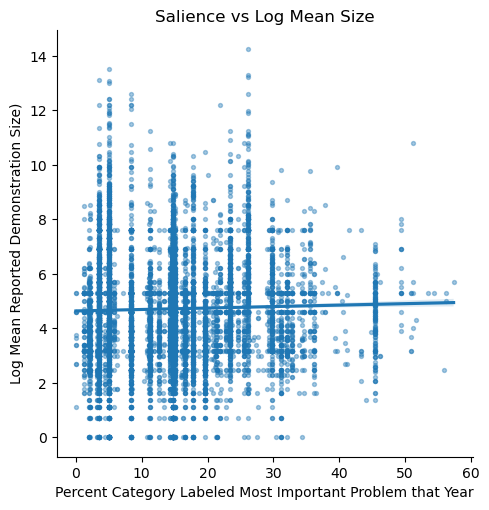

In [51]:
sns.lmplot(x = 'perc', y = target_cont,   
            data = demo_data,
            fit_reg = True, scatter_kws={'alpha': 0.4, 's': 8 })
plt.xlabel("Percent Category Labeled Most Important Problem that Year")
plt.ylabel("Log Mean Reported Demonstration Size)")
plt.title("Salience vs Log Mean Size")
plt.show()

#### Linear Model

In [52]:
ols_log_size_mean_by_perc = ols(formula = 'log_size_mean ~ perc', data = demo_data)
ols_log_size_mean_by_perc_fit = ols_log_size_mean_by_perc.fit()
print( ols_log_size_mean_by_perc_fit.summary() )

                            OLS Regression Results                            
Dep. Variable:          log_size_mean   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     9.961
Date:                Tue, 09 Dec 2025   Prob (F-statistic):            0.00160
Time:                        12:23:34   Log-Likelihood:                -29151.
No. Observations:               14832   AIC:                         5.831e+04
Df Residuals:                   14830   BIC:                         5.832e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6385      0.028    163.077      0.0

Despite having an $R^2$ of 0.001, the $F$-statistic is at 11.73—highly significant. Indeed, both the intercept and perc have very small p-values.

In other words, though the percent category labeled Most Important Problem that year does not explain nearly any of the variance in the log mean reported size of demonstrations, it is nevertheless explaining some of it.

In [53]:
ols_log_size_mean_by_perc_pop = ols(formula = 'log_size_mean ~ perc + DP05_0001PE', data = demo_data)
ols_log_size_mean_by_perc_pop_fit = ols_log_size_mean_by_perc_pop.fit()
print( ols_log_size_mean_by_perc_pop_fit.summary() )

                            OLS Regression Results                            
Dep. Variable:          log_size_mean   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     23.60
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           5.85e-11
Time:                        12:23:34   Log-Likelihood:                -29133.
No. Observations:               14832   AIC:                         5.827e+04
Df Residuals:                   14829   BIC:                         5.829e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.5775      0.030    151.996      

Adding in population greatly boosts the predictive power.

In [54]:
# ols_log_size_mean_by_all = ols(formula = 'log_size_mean ~ .', data = demo_data)
# ols_log_size_mean_by_all_fit = ols_log_size_mean_by_all.fit()
# print( ols_log_size_mean_by_all.summary() )

In [55]:
demo_lm = LinearRegression()  # instantiate
demo_lm.fit(X_train, y_train_cont)
print("R^2 (with the test set):", demo_lm.score(X_test, y_test_cont))
print("R^2 (with the train set):", demo_lm.score(X_train, y_train_cont))

R^2 (with the test set): -0.15642354529580937
R^2 (with the train set): 0.27818892366226855


The linear model with all variables overfits; worse than the null model.

##### LASSO Regression

"The advantage of using a cross-validation estimator over the canonical estimator class along with grid search is that they can take advantage of warm-starting by reusing precomputed results in the previous steps of the cross-validation process. This generally leads to speed improvements" (https://scikit-learn.org/stable/glossary.html#term-cross-validation-estimator).

In [56]:
demo_lasso = LassoCV(n_alphas=100, max_iter=10000, random_state=seed, n_jobs=6)
demo_lasso.fit(X_train, y_train_cont)

print('LASSO Regression model accuracy (with the test set):', demo_lasso.score(X_test, y_test_cont))
print('LASSO Regression model accuracy (with the train set):', demo_lasso.score(X_train, y_train_cont))

LASSO Regression model accuracy (with the test set): 0.18672887255597936
LASSO Regression model accuracy (with the train set): 0.21958787761663157


In [57]:
# pd.DataFrame([feature_names, demo_lasso.coef_]).T.rename(columns={0:"var_name",1:"coef"}).set_index("var_name").sort_values(by="coef")

lasso_coefs = pd.Series(demo_lasso.coef_,index=feature_names, name="coef")
lasso_coefs_sort = pd.DataFrame([lasso_coefs,lasso_coefs.abs().rename("abs_coef")]).T.sort_values("abs_coef",ascending=False)
lasso_coefs_sort = lasso_coefs_sort[lasso_coefs_sort["coef"] != 0]
lasso_coefs_sort.head(60)

coef  abs_coef
type_march                    0.418864  0.418864
type_protest                 -0.302861  0.302861
type_parade                   0.148044  0.148044
problemname_Rights            0.138886  0.138886
problemname_Public Safety     0.131716  0.131716
problemname_Fiscal Policy     0.116215  0.116215
type_walk-out                 0.104975  0.104975
perc                          0.101703  0.101703
problemname_Foreign Policy   -0.091223  0.091223
problemname_Politics          0.072837  0.072837
type_counterprotest          -0.061861  0.061861
year                          0.058558  0.058558
DP03_0053PE                  -0.055814  0.055814
type_hunger strike           -0.049166  0.049166
DP04_0002PE                   0.048181  0.048181
DP05_0002PE                  -0.041110  0.041110
type_kneeling protest        -0.040792  0.040792
FIPS Code_17031               0.040124  0.040124
FIPS Code_26065               0.037447  0.037447
DP04_0037E                   -0.037044  0.037044
FIPS Code_34003              -0.037034  0.037034
DP03_0125PE                  -0.034776  0.034776
DP04_0042PE                  -0.033576  0.033576
CBSA Code_45180              -0.033195  0.033195
FIPS Code_05045              -0.031981  0.031981
type_die-in                  -0.029530  0.029530
CBSA Code_46100              -0.028377  0.028377
FIPS Code_06041              -0.028195  0.028195
FIPS Code_29107              -0.028061  0.028061
FIPS Code_51101              -0.027195  0.027195
type_festival                 0.025638  0.025638
type_counter protest         -0.025270  0.025270
FIPS Code_51107              -0.024931  0.024931
CBSA Code_40740              -0.024350  0.024350
FIPS Code_27123               0.022815  0.022815
FIPS Code_13015              -0.022510  0.022510
FIPS Code_13223              -0.022510  0.022510
type_mock execution          -0.022439  0.022439
type_aircraft flyover        -0.021952  0.021952
FIPS Code_08093              -0.021839  0.021839
type_protest vandalism       -0.021660  0.021660
CBSA Code_32300              -0.021432  0.021432
type_art projection          -0.021142  0.021142
CBSA Code_23180               0.020816  0.020816
CBSA Code_19300              -0.020733  0.020733
FIPS Code_54039               0.020256  0.020256
FIPS State Code_51           -0.020216  0.020216
CBSA Code_43300              -0.019714  0.019714
CBSA Code_49620              -0.019686  0.019686
type_self-immolation protest -0.019548  0.019548
FIPS Code_16001               0.019059  0.019059
FIPS State Code_24           -0.018912  0.018912
FIPS Code_22047              -0.018011  0.018011
CBSA Code_19820               0.017975  0.017975
CBSA Code_16620               0.017532  0.017532
DP05_0071PE                   0.017424  0.017424
FIPS Code_01073               0.016939  0.016939
FIPS Code_36055               0.016689  0.016689
FIPS Code_13067              -0.016246  0.016246
DP03_0077PE                  -0.016142  0.016142

#### Logistic Regression

In [58]:
demo_logit = LogisticRegression(penalty="l2", C=1, random_state=seed, max_iter=1000)
demo_logit.fit(X_train, y_train_cat)
# Cross-validation
kfold = KFold(5, random_state = seed, shuffle = True)
grid_logit = GridSearchCV(demo_logit, {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}, cv = kfold, scoring = "accuracy", n_jobs=6)
grid_logit.fit(X_train, y_train_cat)

print( grid_logit.best_params_ )
print( grid_logit.cv_results_[('mean_test_score')] )

demo_logit = grid_logit.best_estimator_

print('Logit model accuracy (with the test set):', demo_logit.score(X_test, y_test_cat))
print('Logit model accuracy (with the train set):', demo_logit.score(X_train, y_train_cat))

{'C': 0.01}
[0.55583649 0.55794353 0.55794353 0.55254952 0.54892541 0.54631268
 0.54285714]
Logit model accuracy (with the test set): 0.5571284125379171
Logit model accuracy (with the train set): 0.6268015170670038


### Tree

#### Regression Tree

In [59]:
demo_dtr = DecisionTreeRegressor(max_depth=3, random_state=seed)
demo_dtr.fit(X_train,y_train_cont)
demo_dtr.score(X_test,y_test_cont)

0.14417389501572087

Run cross-validation to choose the best `max_depth` and `criterion`.

In [60]:
param_grid_dtr = {'max_depth': range(3, 15)}
                 #'criterion':('absolute_error', 'squared_error', 'friedman_mse', 'poisson')} 
# Cross-validation
grid_dtr = GridSearchCV(demo_dtr, param_grid_dtr, cv = kfold, scoring = None, n_jobs=6)
grid_dtr.fit(X_train, y_train_cont)

print( grid_dtr.best_params_ )
print( grid_dtr.cv_results_[('mean_test_score')] )
demo_dtr = grid_dtr.best_estimator_

{'max_depth': 6}
[ 0.14812245  0.16731579  0.17027533  0.17241069  0.1611117   0.14299829
  0.11036709  0.08475928  0.04373906  0.01503987 -0.01727454 -0.05137157]


In [61]:
demo_dtr.score(X_test,y_test_cont)

0.1769892216157133

Tree does decently well, even on the test data.

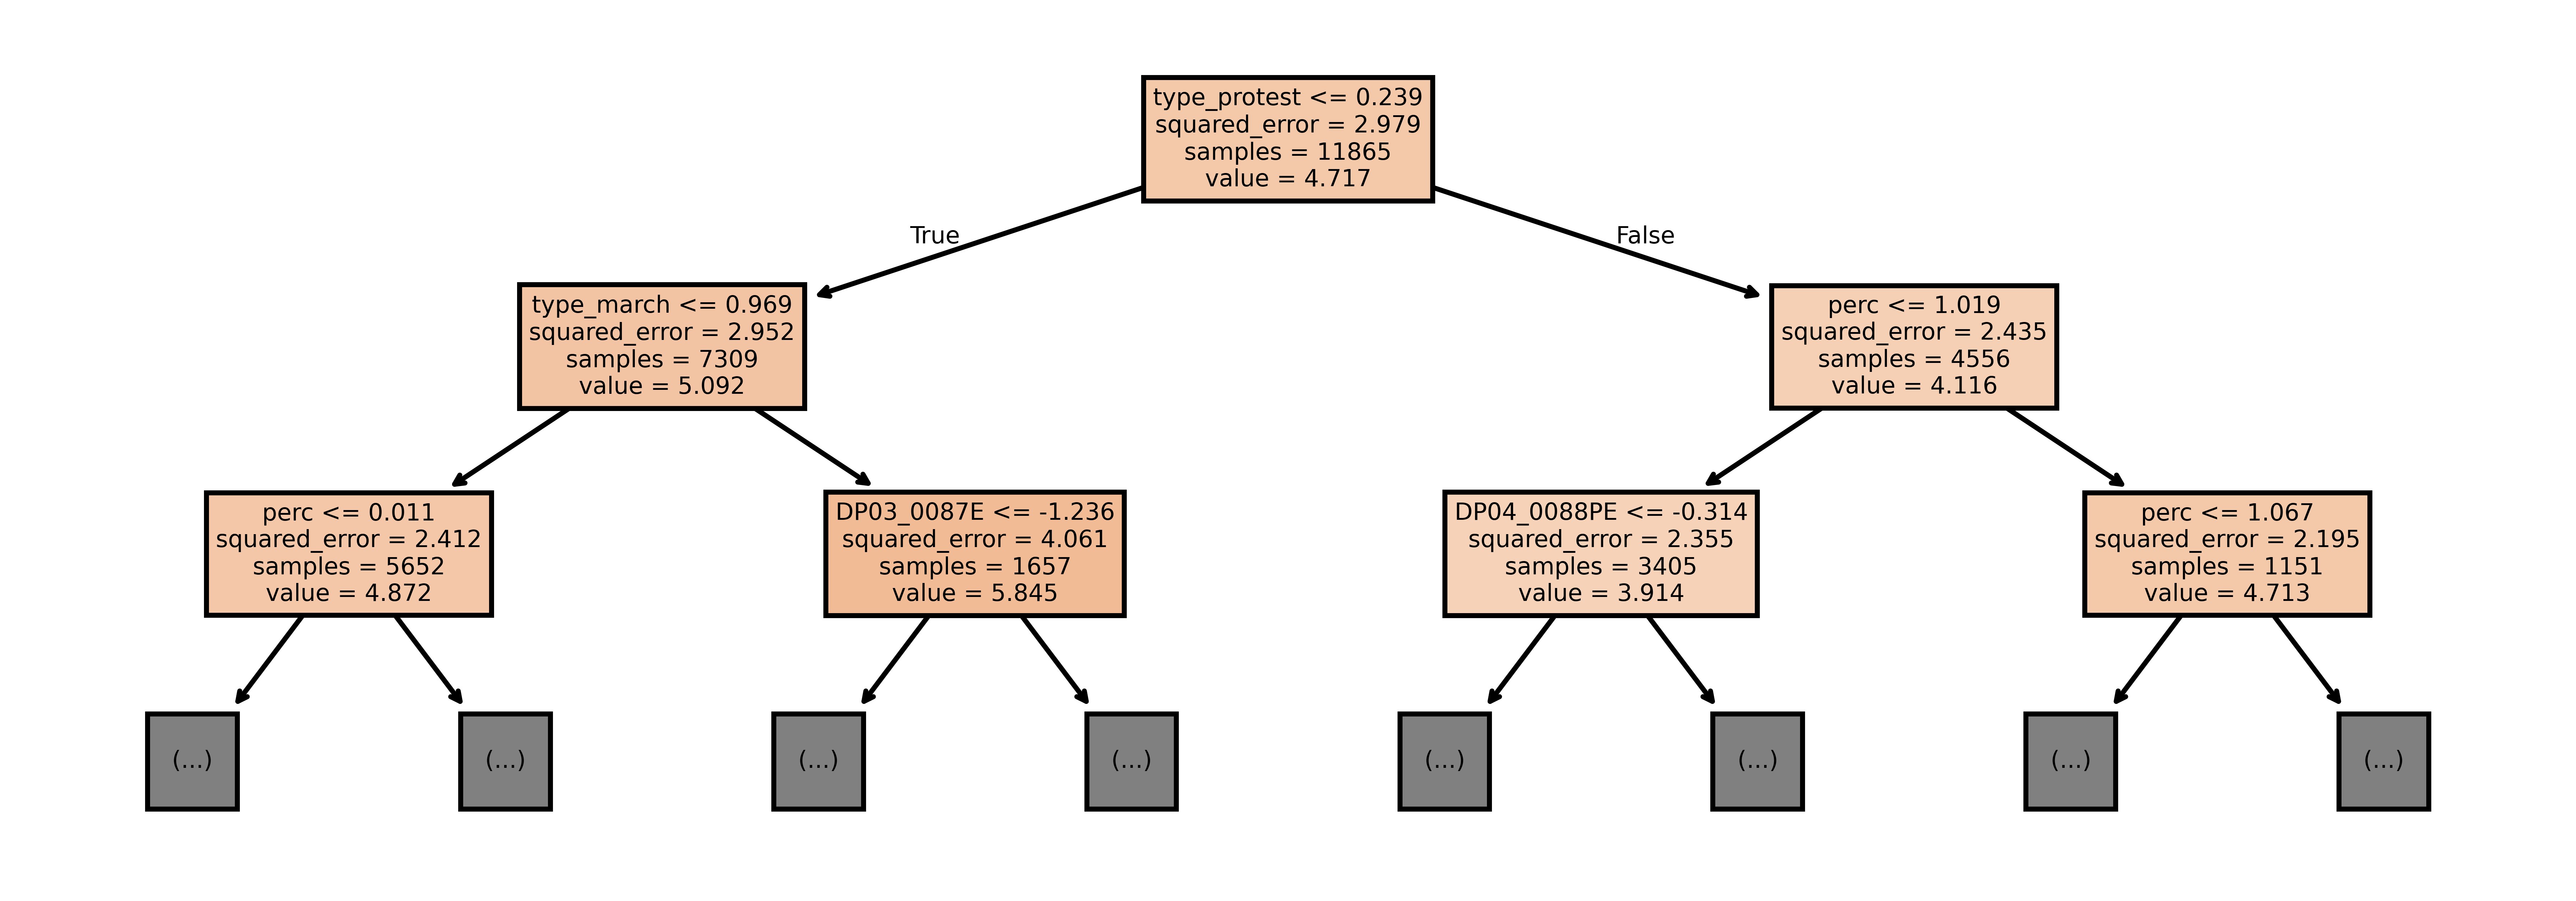

In [62]:
plt.figure(dpi=1000,figsize=(9,3))
plot_tree(demo_dtr, feature_names = np.setdiff1d(demo_train.columns, targets), filled=True, max_depth=2)
plt.show()

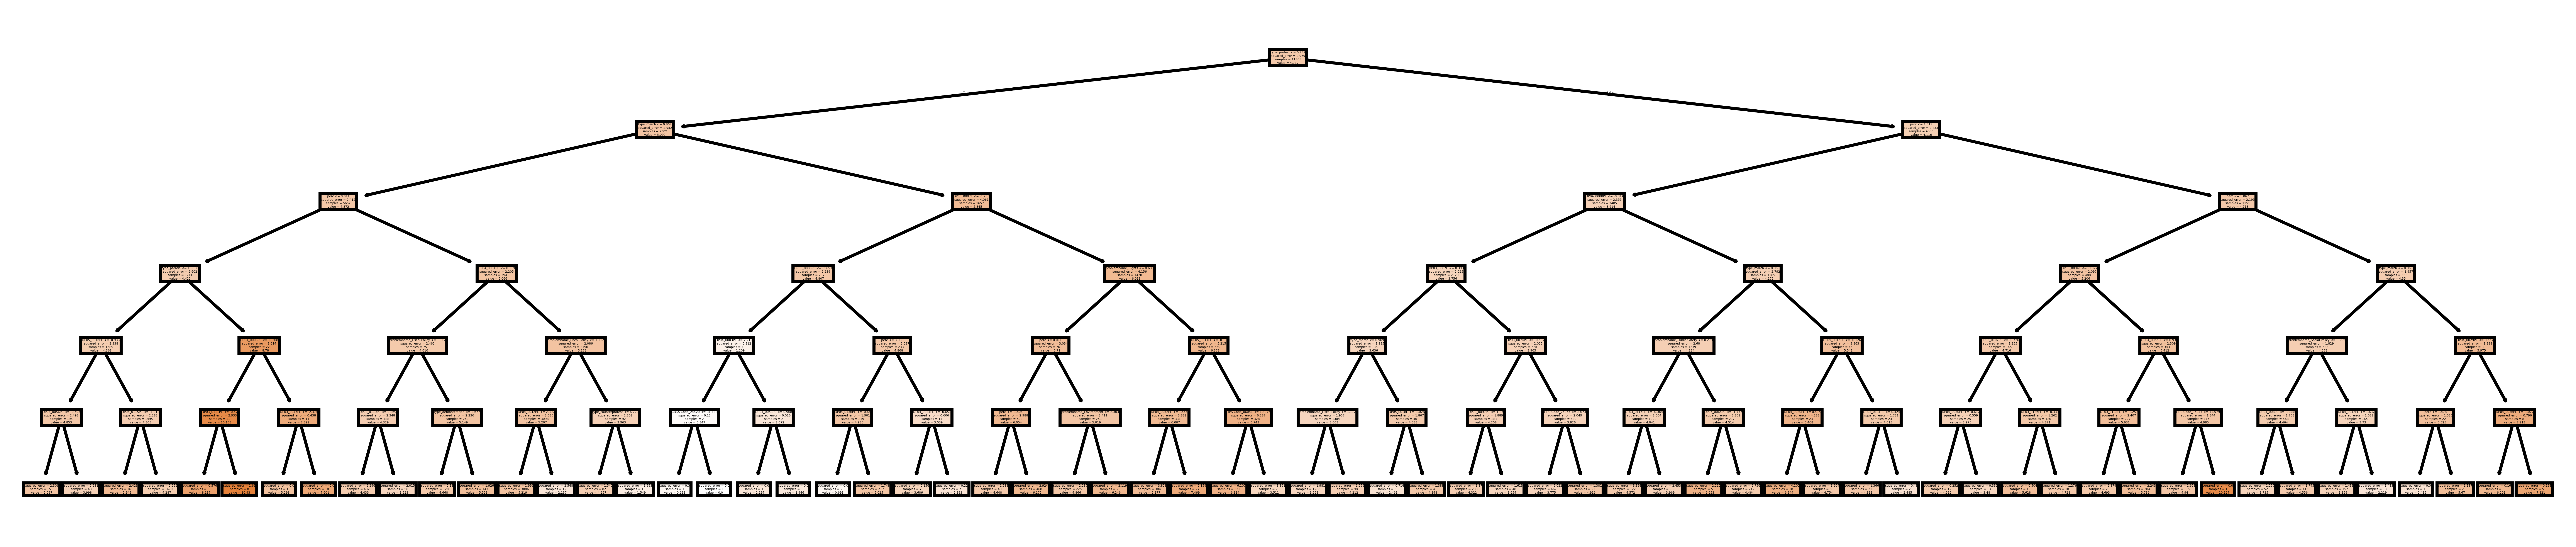

In [63]:
plt.figure(dpi=1000,figsize=(15,3))
plot_tree(demo_dtr, feature_names = np.setdiff1d(demo_train.columns, targets), filled=True)
plt.show()

`type_protest`, `type_march`, and `perc` were the three most important variables. Other important ones include `DP03_0087PE` (Mean family income in 2024 inflation-adjusted dollars)—higher has larger crowds—and `DP04_0088PE` (Percent of owner-occupied units that are worth $1,000,000 or more)—higher has larger crowds.

#### Classification Tree

In [64]:
demo_dtc = DecisionTreeClassifier(max_depth=3, random_state=seed)
demo_dtc.fit(X_train,y_train_cat)
demo_dtc.score(X_test,y_test_cat)

0.5840916750926862

In [65]:
param_grid_dtc = {'max_depth': range(3, 15, 2),
                  "criterion":("gini","entropy","log_loss")}
# Cross-validation
grid_dtc = GridSearchCV(demo_dtc, param_grid_dtc, cv = kfold, scoring = "accuracy", n_jobs=6)
grid_dtc.fit(X_train, y_train_cat)

print( grid_dtc.best_params_ )
print( grid_dtc.cv_results_[('mean_test_score')] )
demo_dtc = grid_dtc.best_estimator_

{'criterion': 'gini', 'max_depth': 7}
[0.56923725 0.56746734 0.57572693 0.56409608 0.5585335  0.54892541
 0.56064054 0.57378845 0.56687737 0.55988201 0.55819638 0.5507796
 0.56064054 0.57378845 0.56687737 0.55988201 0.55819638 0.5507796 ]


In [66]:
demo_dtc.score(X_test,y_test_cat)

0.570273003033367

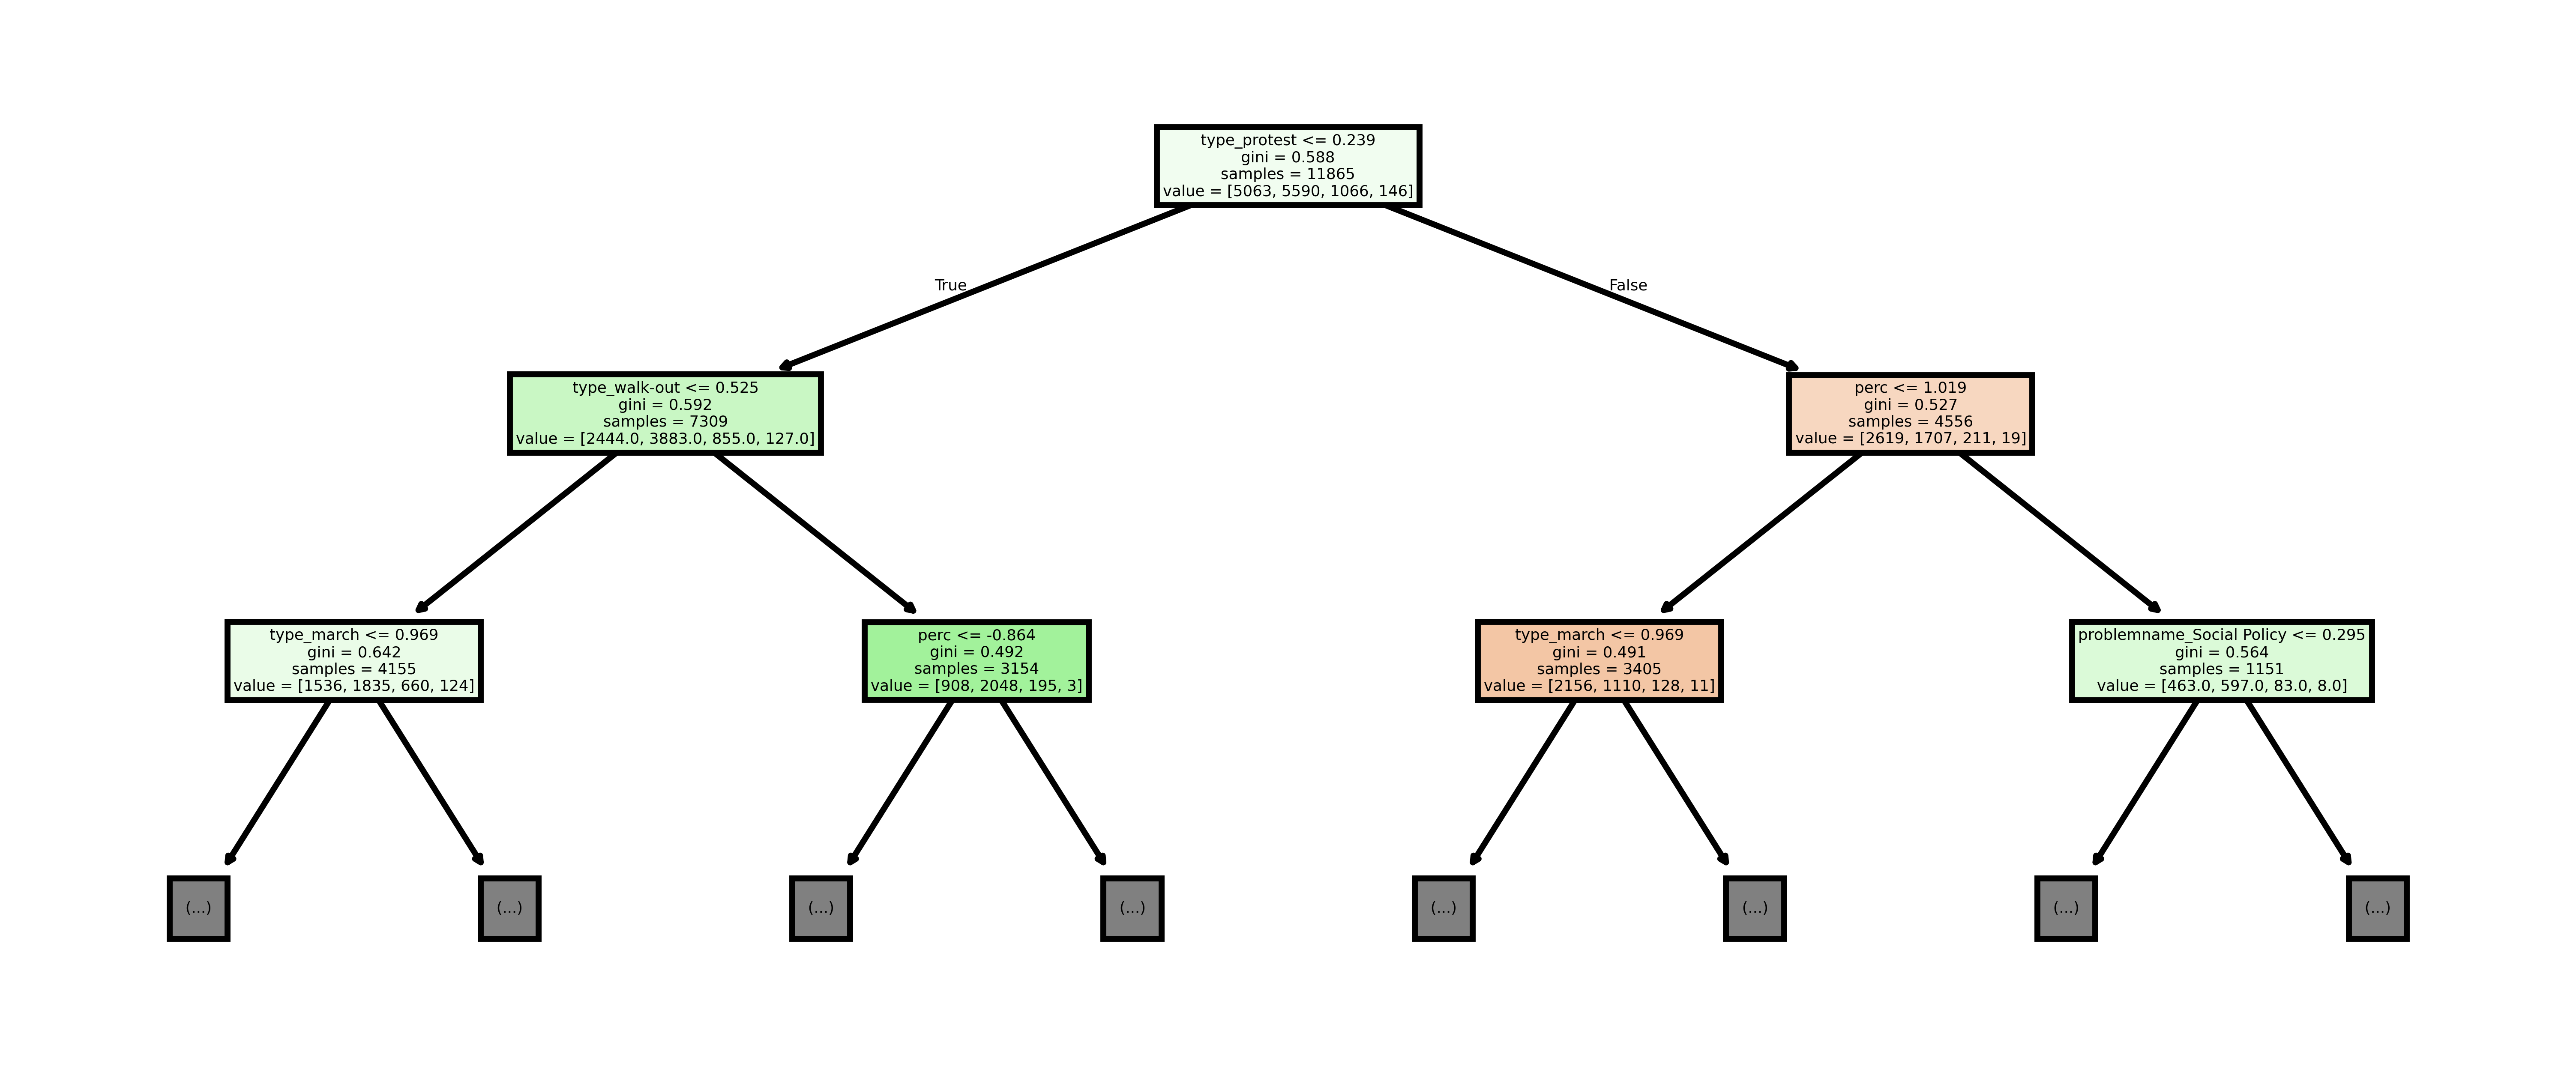

In [67]:
plt.figure(dpi=1000,figsize=(7.5,3))
plot_tree(demo_dtc, feature_names = np.setdiff1d(demo_train.columns, targets), filled=True, max_depth=2)
plt.show()

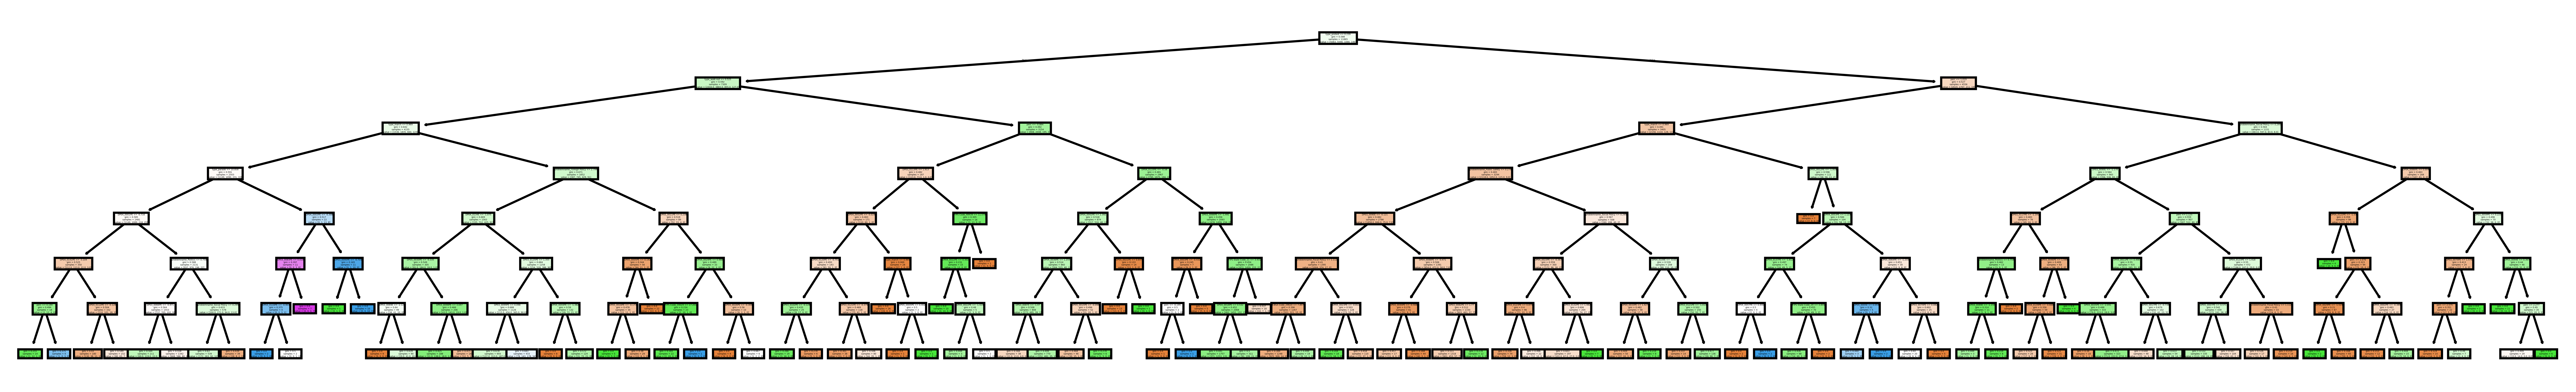

In [68]:
plt.figure(dpi=1000,figsize=(21,3))
plot_tree(demo_dtc, feature_names=np.setdiff1d(demo_train.columns, targets), filled=True)
plt.show()

`type_protest`, `type_walk-out`, `walk-out`, and `perc` were the three most important variables. Other important ones include `type_march`, `problemname_Social Policy`.

Interesting to note are `DP02_0123PE` (percent of the population 5 years or older that speaks a language at home other than English and that speaks English less than "very well")—higher percents have larger protests—and `DP02_0031PE` (percent of females 15 years old or older who are married)—higher percents have larger protests.

### Random Forest

#### Random Forest Regression

In [69]:
demo_rfr = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=seed, n_jobs=6)  # instantiate
demo_rfr.fit(X_train, y_train_cont)

print("R^2 (with the test data):", demo_rfr.score(X_test, y_test_cont))

R^2 (with the test data): 0.16191303281986158


In [70]:
param_grid_rf = {
    'max_depth': [3, 5, 7, 9, 11],
    'n_estimators': [5, 10, 15, 20, 25, 30]
} 
# Cross-validation
grid_rfr = GridSearchCV(demo_rfr, param_grid_rf, cv = kfold, scoring = None, n_jobs=6)
grid_rfr.fit(X_train, y_train_cont)

print( grid_rfr.best_params_ )
print( grid_rfr.cv_results_[('mean_test_score')] )
demo_rfr = grid_rfr.best_estimator_

{'max_depth': 9, 'n_estimators': 30}
[0.15768497 0.16192606 0.16214603 0.16208336 0.16329129 0.16385098
 0.18776618 0.19346854 0.19431596 0.19497176 0.19588285 0.19641441
 0.19264551 0.20388399 0.20754226 0.208607   0.21030852 0.21088775
 0.1844065  0.20097346 0.20660146 0.20845569 0.21011724 0.21117339
 0.16084529 0.1854004  0.1944433  0.19801754 0.20104798 0.20338438]


Best: max depth 9, 30 estimators

In [71]:
demo_rfr.score(X_test, y_test_cont)

0.20058453473078486

In [72]:
rfr_feature_imp = pd.DataFrame({'Feature': feature_names, 'Gini Importance': demo_rfr.feature_importances_}).sort_values(
    'Gini Importance', ascending=False)
rfr_feature_imp = rfr_feature_imp.merge(census_vars[["VARIABLE","LABEL"]], how="left", left_on="Feature", right_on="VARIABLE").drop(columns="VARIABLE").fillna("")
rfr_feature_imp.head(20)

Feature  Gini Importance  \
0                 type_protest         0.184465   
1                         perc         0.118341   
2                   type_march         0.110952   
3                  type_parade         0.030304   
4    problemname_Fiscal Policy         0.020216   
5           problemname_Rights         0.018637   
6                  DP04_0054PE         0.012728   
7    problemname_Social Policy         0.012473   
8                   type_rally         0.011043   
9                  DP04_0042PE         0.009704   
10                 DP04_0136PE         0.009179   
11  problemname_Foreign Policy         0.008523   
12                 DP05_0011PE         0.007093   
13                 DP04_0055PE         0.006382   
14                 DP03_0085PE         0.006218   
15   problemname_Public Safety         0.005953   
16         type_counterprotest         0.005845   
17                  DP03_0087E         0.005586   
18        problemname_Politics         0.005479   
19                 DP04_0081PE         0.005265   

                                                                                                                                           LABEL  
0                                                                                                                                                 
1                                                                                                                                                 
2                                                                                                                                                 
3                                                                                                                                                 
4                                                                                                                                                 
5                                                                                                                                                 
6                                                       Percent!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 1990 to 1999  
7                                                                                                                                                 
8                                                                                                                                                 
9                                                                                             Percent!!BEDROOMS!!Total housing units!!3 bedrooms  
10  Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)  
11                                                                                                                                                
12                                                                                                          Percent!!SEX AND AGE!!35 to 44 years  
13                                                      Percent!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 1980 to 1989  
14                                                 Percent!!INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Families!!$200,000 or more  
15                                                                                                                                                
16                                                                                                                                                
17                                    Estimate!!INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Families!!Mean family income (dollars)  
18                                                                                                                                                
19         

New information: `DP02_0064PE` (percent of the population 25 years old or older that has graduated from high school or the equivalent) and `DP02_0061PE` (percent of the population 25 years old or older that has a 9th–12th-grade education without a high school diploma) are also important, as is local effects (a la the categorical `FIPS Code`). Rounding out the top 20 are `DP03_0085PE` (percent of families whose income and benefits (in 2024 inflation-adjusted dollars) equal or exceed $200,000), `DP02_0065PE

#### Random Forest Classification

In [73]:
demo_rfc = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=seed, n_jobs=6)  # instantiate
demo_rfc.fit(X_train, y_train_cat)

print('RFC model accuracy (with the test set):', demo_rfc.score(X_test, y_test_cat))
print('RFC model accuracy (with the train set):', demo_rfc.score(X_train, y_train_cat))

RFC model accuracy (with the test set): 0.523087293562521
RFC model accuracy (with the train set): 0.5372945638432364


In [74]:
# Cross-validation
grid_rfc = GridSearchCV(demo_rfc, param_grid_rf, cv = kfold, scoring = None, n_jobs=6)
grid_rfc.fit(X_train, y_train_cat)

print( grid_rfc.best_params_ )
print( grid_rfc.cv_results_[('mean_test_score')])
demo_rfc = grid_rfc.best_estimator_

{'max_depth': 11, 'n_estimators': 30}
[0.52465234 0.50931311 0.5179941  0.51748841 0.51917404 0.517067
 0.51672988 0.51959545 0.52330383 0.52633797 0.52718078 0.52701222
 0.53173198 0.52734935 0.53147914 0.52920354 0.53080489 0.5325748
 0.52743363 0.53147914 0.53409187 0.53442899 0.53021492 0.53375474
 0.52751791 0.52911926 0.53333333 0.53426043 0.53518753 0.53687316]


In [75]:
demo_rfc.score(X_test, y_test_cat)

0.5308392315470172

In [76]:
rfc_feature_imp = pd.DataFrame({'Feature': feature_names, 'Gini Importance': demo_rfc.feature_importances_}).sort_values(
    'Gini Importance', ascending=False)
rfc_feature_imp = rfc_feature_imp.merge(census_vars[["VARIABLE","LABEL"]], how="left", left_on="Feature", right_on="VARIABLE").drop(columns="VARIABLE").fillna("")
rfc_feature_imp.head(20)

Feature  Gini Importance  \
0                         perc         0.056612   
1                 type_protest         0.052579   
2                   type_march         0.045003   
3    problemname_Social Policy         0.033779   
4    problemname_Public Safety         0.031958   
5                type_walk-out         0.027177   
6                   type_rally         0.018971   
7           problemname_Rights         0.018331   
8         problemname_Politics         0.015329   
9    problemname_Fiscal Policy         0.013887   
10         problemname_Economy         0.012482   
11                 DP04_0055PE         0.009833   
12                 DP04_0056PE         0.007654   
13                 DP04_0054PE         0.007399   
14                 DP04_0053PE         0.006564   
15  problemname_Foreign Policy         0.006220   
16     problemname_Environment         0.006102   
17                 DP05_0063PE         0.005647   
18                  DP03_0062E         0.005143   
19          type_demonstration         0.005115   

                                                                                                                      LABEL  
0                                                                                                                            
1                                                                                                                            
2                                                                                                                            
3                                                                                                                            
4                                                                                                                            
5                                                                                                                            
6                                                                                                                            
7                                                                                                                            
8                                                                                                                            
9                                                                                                                            
10                                                                                                                           
11                                 Percent!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 1980 to 1989  
12                             Percent!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 1979 and earlier  
13                                 Percent!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 1990 to 1999  
14                                 Percent!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 2000 to 2009  
15                                                                                                                           
16                                                                                                                           
17                               Percent!!RACE!!Race alone or in combination with one or more other races!!Total population  
18  Estimate!!INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)  
19

Here, we see entirely different demographic variables: for some reason, the percent of occupied housing units moved into in different decades continuese to be significant.

### K Nearest Neighbors

#### K Nearest Neighbors Regression

In [77]:
demo_knnr = KNeighborsRegressor()
param_grid_knn = {'n_neighbors': range(1,31)} 
# Cross-validation
grid_knnr = GridSearchCV(demo_knnr, param_grid_knn, cv = kfold, scoring = None, n_jobs=6)
grid_knnr.fit(X_train, y_train_cont)

print( grid_knnr.best_params_ )
print( grid_knnr.cv_results_[('mean_test_score')] )
demo_knnr=grid_knnr.best_estimator_

{'n_neighbors': 26}
[-6.53035414e-01 -2.92669827e-01 -1.79354868e-01 -1.16417197e-01
 -7.81538518e-02 -5.92372696e-02 -3.78634459e-02 -2.80372772e-02
 -1.89615944e-02 -1.24778031e-02 -8.13331838e-03 -3.17380360e-03
 -4.03993555e-04  3.64452251e-03  8.27996933e-03  1.07450584e-02
  1.29466114e-02  1.76289036e-02  1.99889714e-02  1.86647782e-02
  2.03448227e-02  2.07297524e-02  2.14586801e-02  2.34203746e-02
  2.50014628e-02  2.70849654e-02  2.56022475e-02  2.51018889e-02
  2.57752494e-02  2.57046253e-02]


In [78]:
demo_knnr.score(X_test, y_test_cont)

0.03926370116160571

KNN tried its best, but it is not the correct model to use here.

#### K Nearest Neighbors Classification

In [79]:
demo_knnc = KNeighborsClassifier()
# Cross-validation
grid_knnc = GridSearchCV(demo_knnc, param_grid_knn, cv = kfold, scoring = "accuracy", n_jobs=6)
grid_knnc.fit(X_train, y_train_cat)

print( grid_knnc.best_params_ )
print( grid_knnc.cv_results_[('mean_test_score')] )
demo_knnc=grid_knnc.best_estimator_

{'n_neighbors': 19}
[0.47576907 0.49313106 0.49692373 0.49599663 0.49768226 0.49919933
 0.49717657 0.4997893  0.49852507 0.50375053 0.50366625 0.50198062
 0.50096924 0.49852507 0.50046355 0.50223346 0.50316056 0.50493047
 0.50535188 0.50273915 0.50088496 0.50105352 0.49801938 0.50004214
 0.50198062 0.50299199 0.50172777 0.50467762 0.50198062 0.5002107 ]


In [80]:
demo_knnc.score(X_test, y_test_cat)

0.5116279069767442

Barely better than chance.

## Model Evaluation

### Check performance metrics like Accuracy, Precision, F1-score, Recall.

In [81]:
print("Logit Classification\n", classification_report( y_test_cat, demo_logit.predict(X_test), zero_division=0.0 ) )
print("Decision Tree Classification\n", classification_report( y_test_cat, demo_dtc.predict(X_test), zero_division=0.0 ) )
print("Random Forest Classification\n", classification_report( y_test_cat, demo_rfc.predict(X_test), zero_division=0.0 ) )
print("K Nearest Neighbors Classification\n", classification_report( y_test_cat, demo_knnc.predict(X_test), zero_division=0.0 ) )

Logit Classification
               precision    recall  f1-score   support

           1       0.58      0.56      0.57      1266
           2       0.56      0.65      0.60      1398
           3       0.30      0.13      0.18       267
           4       0.29      0.06      0.09        36

    accuracy                           0.56      2967
   macro avg       0.43      0.35      0.36      2967
weighted avg       0.54      0.56      0.54      2967

Decision Tree Classification
               precision    recall  f1-score   support

           1       0.58      0.63      0.60      1266
           2       0.58      0.62      0.60      1398
           3       0.32      0.13      0.19       267
           4       0.00      0.00      0.00        36

    accuracy                           0.57      2967
   macro avg       0.37      0.34      0.35      2967
weighted avg       0.55      0.57      0.56      2967

Random Forest Classification
               precision    recall  f1-score   su

Recall of the biggest demonstration sizes is more important here, as it is better to allocate resources where they are not needed than to not when they are necessary. As such, though the best logistic regression model has a lower overall accuracy than the best decision tree classifier, as it is slightly better at predicting those larger demonstration sizes, that looks to be the best model.

### Plot the One vs. Rest multiclass ROC-AUC curves for the best trained classifiers

ROC-AUC can only be applied to binary classifiers. As such, a One vs. Rest strategy may be used, plotting multiple curves: one for each class, where a failure is a classification of any of the others.

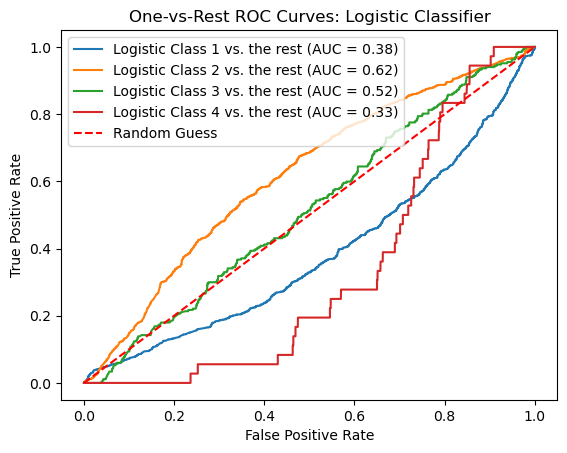

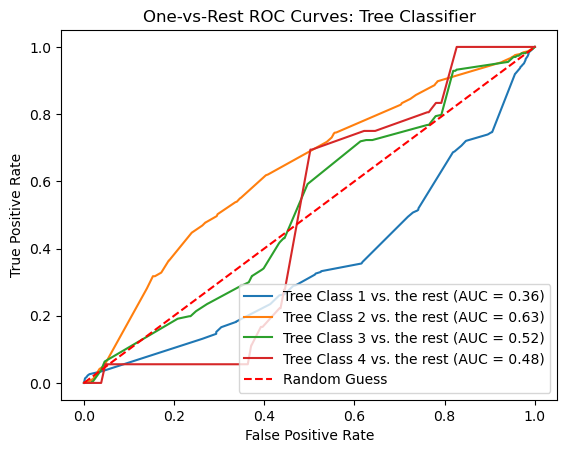

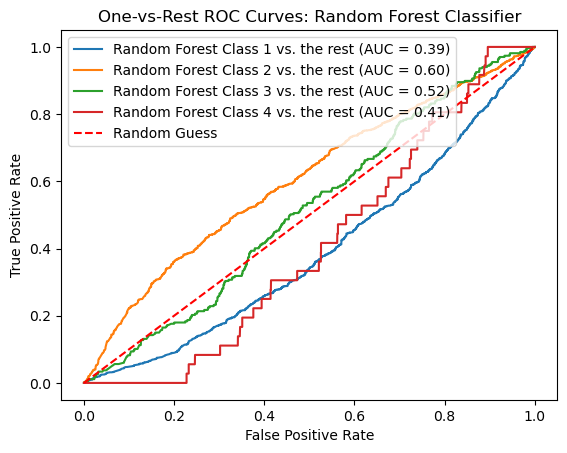

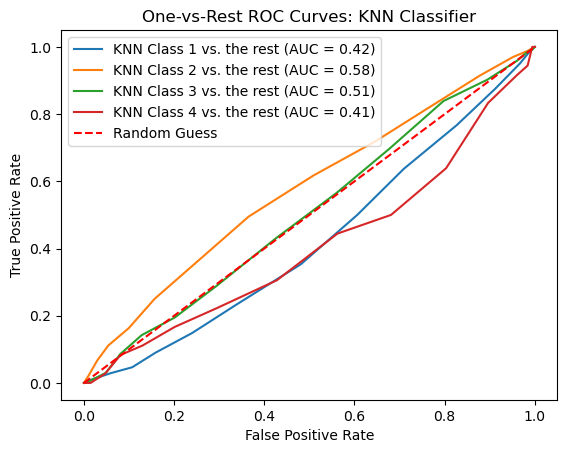

In [82]:
label_binarizer = LabelBinarizer().fit(y_train_cat) # sourced from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
y_test_cat_onehot = label_binarizer.transform(y_test_cat)
# y_test_cat_onehot.shape  # (n_samples, n_classes)

class_names=y_test_cat.unique().sort_values()

def OvR_ROC_AUC(X_test, y_test_onehot, cat_model, cat_model_name, classes, class_names):
    for class_of_interest in classes:
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        
        fpr, tpr, _ = roc_curve(y_test_onehot[:, class_id], cat_model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cat_model_name} Class {class_names[class_id]} vs. the rest (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'One-vs-Rest ROC Curves: {cat_model_name} Classifier')
    plt.legend()
    plt.show()

OvR_ROC_AUC(X_test, y_test_cat_onehot, cat_model=demo_logit, cat_model_name="Logistic", classes=label_binarizer.classes_, class_names=class_names)
OvR_ROC_AUC(X_test, y_test_cat_onehot, cat_model=demo_dtc, cat_model_name="Tree", classes=label_binarizer.classes_, class_names=class_names)
OvR_ROC_AUC(X_test, y_test_cat_onehot, cat_model=demo_rfc, cat_model_name="Random Forest", classes=label_binarizer.classes_, class_names=class_names)
OvR_ROC_AUC(X_test, y_test_cat_onehot, cat_model=demo_knnc, cat_model_name="KNN", classes=label_binarizer.classes_, class_names=class_names)



# # Logit
# fpr, tpr, _ = roc_curve(y_test_cat, demo_logit.predict_proba(X_test)[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label=f'Logistic (AUC = {roc_auc:.2f})')
# # Decision Tree
# fpr, tpr, _ = roc_curve(y_test_cat, demo_dtc.predict_proba(X_test)[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label=f'Tree (AUC = {roc_auc:.2f})')
# # Random Forest
# fpr, tpr, _ = roc_curve(y_test_cat, demo_rfc.predict_proba(X_test)[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
# # KNN
# fpr, tpr, _ = roc_curve(y_test_cat, demo_knnc.predict_proba(X_test)[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curves for Two Models')
# plt.legend()
# plt.show()

Judging by the ROC-AUC curves, the best decision tree would appear to be the best model. It is the worst at predicting Class 1s, but as that is the smallest class, it is the least essential to distribute resources appropriately for.

### Plot the residuals for the best trained regressors

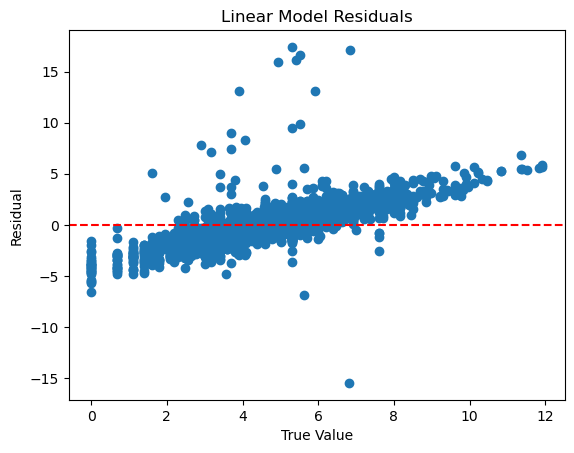

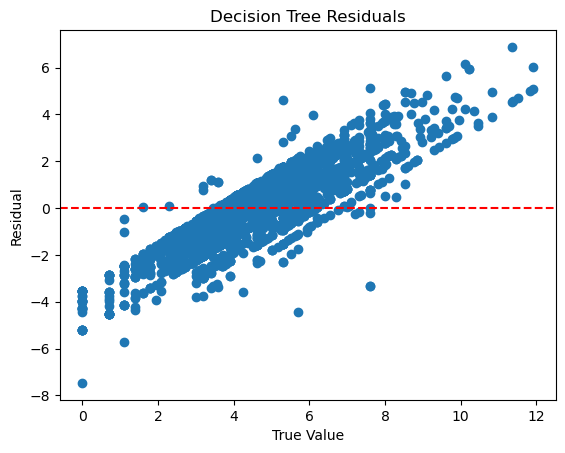

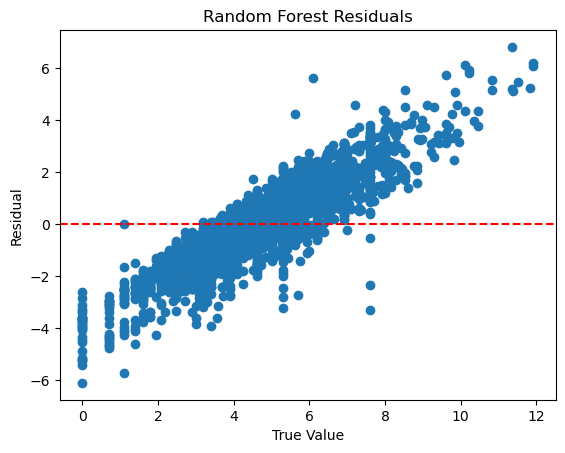

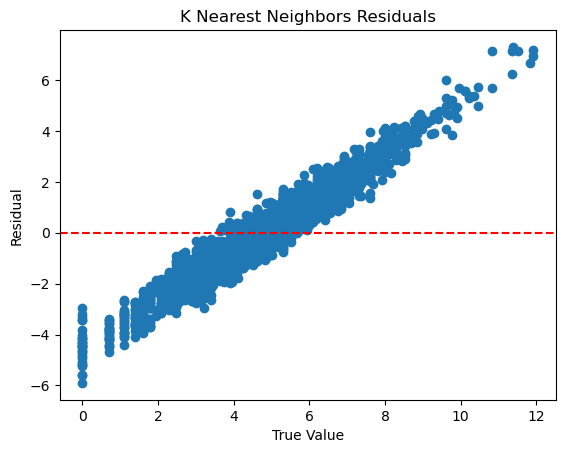

In [83]:
# linear model
plt.scatter(y_test_cont, y_test_cont - demo_lm.predict(X_test))
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("True Value")
plt.ylabel('Residual')
plt.title("Linear Model Residuals")
plt.show()

# tree
plt.scatter(y_test_cont, y_test_cont - demo_dtr.predict(X_test))
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("True Value")
plt.ylabel('Residual')
plt.title("Decision Tree Residuals")
plt.show()

# random forest
plt.scatter(y_test_cont, y_test_cont - demo_rfr.predict(X_test))
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("True Value")
plt.ylabel('Residual')
plt.title("Random Forest Residuals")
plt.show()

# knn
plt.scatter(y_test_cont, y_test_cont - demo_knnr.predict(X_test))
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("True Value")
plt.ylabel('Residual')
plt.title("K Nearest Neighbors Residuals")
plt.show()

The residuals all have a clear direction. The linear model appears flattest, but only because it is squashed to show all of the residuals.

In [84]:
print("R^2 With the Test Data")
print(f"Linear Model: {demo_lm.score(X_test,y_test_cont):.2f}")
print(f"Decision Tree: {demo_dtr.score(X_test,y_test_cont):.2f}")
print(f"Random Forest: {demo_rfr.score(X_test,y_test_cont):.2f}")
print(f"K Nearest Neighbors: {demo_knnr.score(X_test,y_test_cont):.2f}")

R^2 With the Test Data
Linear Model: -0.16
Decision Tree: 0.18
Random Forest: 0.20
K Nearest Neighbors: 0.04


Random Forest explains the most variance. The linear model is worse than the null model, and the KNN regressor is not far off.

## Dimensionality Reduction

### Primary Component Analysis

In [85]:
# PCA Computations
# X_avg = np.mean(X_train, axis = 0)
# B = X_train - np.tile(X_avg, (len(X_train), 1))

# U, S, VT = np.linalg.svd(B / np.sqrt(len(X_train)), full_matrices=True)
# V = VT.T

# #t = np.arange(0, 1, 0.1)
# # plt.plot(t, V[1, 0]/V[0, 0] * t)
# # plt.plot(t, V[1, 1]/V[0, 1] * t)
# plt.quiver([X_avg[0], X_avg[0]], [X_avg[1],X_avg[1]], V[0,:], V[1,:], scale=8, zorder=2, color=['b', 'r'])
# plt.show()

# theta = 2 * np.pi * np.arange(0, 1, 0.01)
# Xstd = np.array([np.cos(theta), np.sin(theta)]).T @ np.diag(S) @ VT

# plt.plot(Xavg[0] +     Xstd[:, 0], Xavg[1] +     Xstd[:,1])
# plt.plot(Xavg[0] + 2 * Xstd[:, 0], Xavg[1] + 2 * Xstd[:,1])
# plt.plot(Xavg[0] + 3 * Xstd[:, 0], Xavg[1] + 3 * Xstd[:,1])
# plt.show()

In [86]:
demo_pca = PCA(n_components=0.95)  # Retain 95% of variance
demo_pca.fit(X_train)

X_train_pca = demo_pca.transform(X_train)
X_test_pca = demo_pca.transform(X_test)

In [87]:
pca_lm = LinearRegression()
pca_lm.fit(X_train_pca,y_train_cont)

print("R^2 (with the test set):", pca_lm.score(X_test_pca, y_test_cont))
print("R^2 (with the train set):", pca_lm.score(X_train_pca, y_train_cont))

R^2 (with the test set): 0.08984001401778652
R^2 (with the train set): 0.1834276932513884


In [88]:
pca_logit = LogisticRegression(penalty="l2", C=1, random_state=seed, max_iter=10000)
pca_logit.fit(X_train_pca,y_train_cat)

# Cross-validation
grid_logit = GridSearchCV(pca_logit, {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}, cv = kfold, scoring = "accuracy", n_jobs=6)
grid_logit.fit(X_train_pca, y_train_cat)

print( grid_logit.best_params_ )
print( grid_logit.cv_results_[('mean_test_score')] )

pca_logit = grid_logit.best_estimator_

print('Logit model accuracy (with the test set):', pca_logit.score(X_test_pca, y_test_cat))
print('Logit model accuracy (with the train set):', pca_logit.score(X_train_pca, y_train_cat))

{'C': 1}
[0.53653603 0.54302571 0.54951538 0.55086389 0.5503582  0.54867257
 0.54479562]
Logit model accuracy (with the test set): 0.5513987192450287
Logit model accuracy (with the train set): 0.6241045090602613


In [89]:
print("Logit Classification\n", classification_report( y_test_cat, pca_logit.predict(X_test_pca) ) )

Logit Classification
               precision    recall  f1-score   support

           1       0.58      0.56      0.57      1266
           2       0.56      0.63      0.59      1398
           3       0.30      0.15      0.20       267
           4       0.22      0.11      0.15        36

    accuracy                           0.55      2967
   macro avg       0.41      0.36      0.38      2967
weighted avg       0.54      0.55      0.54      2967



Slightly worse accuracy, at the advantage of a higher recall for Class 3 and 4.

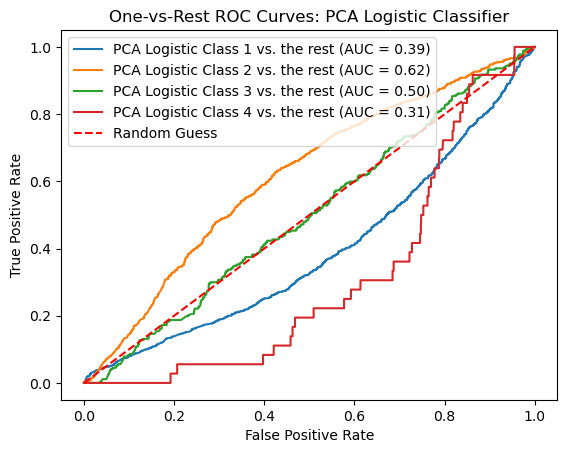

In [90]:
OvR_ROC_AUC(X_test_pca, y_test_cat_onehot, cat_model=pca_logit, cat_model_name="PCA Logistic", classes=label_binarizer.classes_, class_names=class_names)